# GLMs to predict syllable probability

In [4]:
prefix = '/home/ines/repositories/'
# prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [5]:
""" 
IMPORTS
"""
import os
import numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# --Machine learning and statistics

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler,  LabelBinarizer
import umap
from sklearn import mixture
import pickle
from scipy.stats import mode
from sklearn.metrics.pairwise import pairwise_distances
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import cosine
from sklearn.decomposition import PCA
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.spatial import distance_matrix, distance

# Get my functions
functions_path =  prefix + 'representation_learning_variability/Functions/'
os.chdir(functions_path)
# from data_processing import save_and_log
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial/4_analyses/5_clustering_analyses/'
os.chdir(functions_path)
# from clustering_functions import calculate_entropy
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
os.chdir(functions_path)
from plotting_functions import create_grouped_gradient_palette
from one.api import ONE
one = ONE(mode='remote')

In [24]:
seq_path = prefix + 'representation_learning_variability/paper-individuality/fig1_segmentation/'
# all_sequences = pd.read_parquet(seq_path+'all_sequences_09-22-2025')
all_sequences = pd.read_parquet(seq_path+'all_sequences_09-29-2025')

In [25]:
all_sequences['session'] = all_sequences['sample'].str[:36]
design_df = all_sequences.pivot(index=['sample', 'session', 'trial_type', 'mouse_name'], columns=['broader_label'], values='binned_sequence').reset_index().dropna()
var_names = design_df.keys()[-4:]
del all_sequences

In [26]:
df = design_df.copy()
df['feedback'] = df['trial_type'].str.split().str[:1].str.join('')
df['choice'] = df['trial_type'].str.split().str[3:4].str.join('')
df['block'] = df['trial_type'].str.split().str[2:3].str.join('')
df['contrast'] = df['trial_type'].str.split().str[1:2].str.join('')
df['side'] = df['choice'].copy()
df.loc[(df['feedback']=='correct') & (df['choice']=='right'), 'side'] = 'left'
df.loc[(df['feedback']=='correct') & (df['choice']=='left'), 'side'] = 'right'

df['session'] = df['sample'].str.split().str[:1].str.join('')
df['trial_id'] = df['sample'].str.split().str[1:2].str.join('')

df['contrast'] = df['contrast'].astype(float)
df['block'] = df['block'].astype(float)

df['choice'] = df['trial_type'].str.split().str[3:4].str.join('')
df.loc[df['choice']=='left', 'choice'] = 0
df.loc[df['choice']=='right', 'choice'] = 1

df.loc[df['feedback']=='correct', 'feedback'] = 1
df.loc[df['feedback']=='incorrect', 'feedback'] = 0

## Separate states per variable (one-hot encoding)

In [27]:
epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']

sequences_choice = np.vstack(df[epoch_to_analyse].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]

use_states = int(max(np.unique(use_sequences)))+1
timesteps = np.shape(use_sequences)[1]
binarized = np.zeros((np.shape(use_sequences)[0], timesteps*use_states))

for t in range(timesteps):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(use_states))
    encoded_arr = label_binarizer.transform(use_sequences[:, t])
    binarized[:, t*use_states:(t+1)*use_states] = encoded_arr

In [28]:
final_matrix = binarized.copy()

## Average per session

In [49]:
session_syllables = pd.DataFrame(final_matrix)
session_syllables['session'] = pd.factorize(design_df['session'].copy())[0]
session_syllables['mouse_name'] = pd.factorize(design_df['mouse_name'].copy())[0]
session_syllables = session_syllables.groupby(['session', 'mouse_name'])[np.arange(0, np.shape(final_matrix)[1], 1)].mean()

([<matplotlib.axis.XTick at 0x7e26b03d28c0>,
 [Text(0, 0, '0'),
  Text(160, 0, '160'),
  Text(320, 0, '320'),
  Text(480, 0, '480'),
  Text(640, 0, '640'),
  Text(800, 0, '800'),
  Text(960, 0, '960'),
  Text(1120, 0, '1120')])

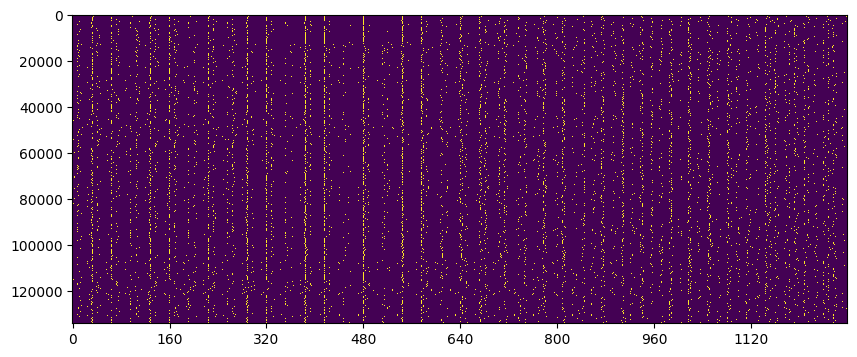

In [47]:
plt.figure(figsize=(10, 4))
plt.imshow(np.array(session_syllables), aspect='auto', cmap='viridis', interpolation='none')
plt.xticks(np.arange(0, np.shape(final_matrix)[1], 160), np.arange(0, np.shape(final_matrix)[1], 160))

In [76]:
test = df.rename(columns={0:'feature'})
test = test[['mouse_name', 'feature']]
formula = f"feature ~ 1"


In [77]:
model = smf.mixedlm(formula, test, groups=test['mouse_name'])
res = model.fit(reml=True, method='lbfgs', warn_convergence=False)

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [95]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
df = session_syllables.reset_index().copy()
df = df.rename(columns={col:str(col) for col in df.columns})

features = [ ... ]  # your feature column names
features = [col for col in df.columns if col not in ['mouse_name', 'session']]
group_col = 'mouse_name'

random_effects = {}

for feature in features:
    
    try:
        # Basic checks
        if feature not in df.columns:
            print(f"Skipping {feature}: not in df")
            continue

        # Convert to numeric (coerce non-numeric -> NaN)
        df[feature] = pd.to_numeric(df[feature], errors='coerce')

        # # Subset rows with non-missing outcome and group
        # sub = df[[feature, group_col]].copy()
        # sub = sub.dropna(subset=[feature, group_col])
        # if sub.shape[0] < 3:
        #     print(f"Skipping {feature}: too few observations after dropping NaNs ({sub.shape[0]})")
        #     continue

        sub = df.rename(columns={feature:'feature'})
        sub = sub[['mouse_name', 'feature']]
        sub['feature'] = np.sqrt(sub['feature'])
        formula = f"feature ~ 1"

        # # Use backticks to handle weird column names
        # formula = f"`{feature}` ~ 1"

        
        model = smf.mixedlm(formula, sub, groups=sub[group_col])
        res = model.fit(reml=True, method='lbfgs', warn_convergence=False)

        print(res.summary())
        # Extract random intercepts: result.random_effects is dict mouse -> {Group: value} (naming depends)
        re = res.random_effects
        # Convert to Series with mouse index -> intercept
        # The dictionary format can vary; inspect `re` if needed
        vals = {}
        for mid, rdict in re.items():
            # rdict is usually {'Group': intercept} or {'Intercept': value}
            # pick the first numeric value
            if isinstance(rdict, dict):
                # find first numeric value
                num = None
                for k, v in rdict.items():
                    if np.isscalar(v):
                        num = float(v)
                        break
                vals[mid] = num
            else:
                # sometimes it's already a scalar
                vals[mid] = float(rdict)

        random_effects[feature] = pd.Series(vals, name=feature)
    except:
        print(feature)

# Combine into DataFrame (mice x features)
if random_effects:
    B = pd.concat(random_effects.values(), axis=1)
    B.index = random_effects[feature].index  # may need more careful alignment
else:
    B = pd.DataFrame()


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mix

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0061  
Min. group size:  1       Log-Likelihood:     189.8647
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.330    0.013 25.800 0.000  0.305  0.356
Group Var    0.009    0.028                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0068  
Min. group size:  1       Log-Likelihood:     178.1334
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estima

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    feature
No. Observations:     218        Method:                REML   
No. Groups:           70         Scale:                 0.0001 
Min. group size:      1          Log-Likelihood:        inf    
Max. group size:      13         Converged:             Yes    
Mean group size:      3.1                                      
---------------------------------------------------------------
          Coef.   Std.Err.    z    P>|z|    [0.025     0.975]  
---------------------------------------------------------------
Intercept -0.001 117224.005 -0.000 1.000 -229754.829 229754.827
Group Var  0.000                                               

7
             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    feature
No. Observations:     218        Method:                REML   
No. Groups:           70         Scale:                 0.0023 

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estima

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0017 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:            Yes    
Mean group size:      3.1                                    
-------------------------------------------------------------
          Coef.  Std.Err.    z   P>|z|    [0.025     0.975]  
-------------------------------------------------------------
Intercept 0.073 478198.582 0.000 1.000 -937251.925 937252.071
Group Var 0.000                                              

14
            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0011 
Min. group size:      1     

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument war

           Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   feature
No. Observations:    218       Method:               REML   
No. Groups:          70        Scale:                0.0000 
Min. group size:     1         Log-Likelihood:       inf    
Max. group size:     13        Converged:            Yes    
Mean group size:     3.1                                    
------------------------------------------------------------
          Coef.   Std.Err.   z    P>|z|   [0.025     0.975] 
------------------------------------------------------------
Intercept -0.001 29700.073 -0.000 1.000 -58211.074 58211.073
Group Var  0.000                                            

23
        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0039  
Min. group size:  1       Log-Likelihood:     230.9365
Max. group

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series 

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0018  
Min. group size:  1       Log-Likelihood:     326.7294
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
              Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept     0.063    0.006 9.934 0.000  0.051  0.076
Group Var     0.002    0.013                          

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0008 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:        

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mix

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0015  
Min. group size:  1       Log-Likelihood:     350.1033
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.091    0.006 15.726 0.000  0.080  0.103
Group Var    0.002    0.012                           

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0014 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:        

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estima

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0028  
Min. group size:  1       Log-Likelihood:     272.5888
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.250    0.009 27.742 0.000  0.233  0.268
Group Var    0.004    0.021                           

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    feature
No. Observations:     218        Method:                REML   
No. Groups:           70         Scale:                 0.0012 
Min. group size:      1          Log-Likelihood:        inf    
Max. group size:      13         Converge

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: U

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0001 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:            Yes    
Mean group size:      3.1                                    
-------------------------------------------------------------
          Coef.  Std.Err.    z   P>|z|    [0.025     0.975]  
-------------------------------------------------------------
Intercept 0.000 104830.203 0.000 1.000 -205463.423 205463.423
Group Var 0.000                                              

51
            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0002 
Min. group size:      1     

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random e

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0020  
Min. group size:  1       Log-Likelihood:     316.5725
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.094    0.007 13.750 0.000  0.081  0.108
Group Var    0.002    0.014                           

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0009 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:        

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The M

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0058  
Min. group size:  1       Log-Likelihood:     196.0778
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.323    0.012 25.925 0.000  0.298  0.347
Group Var    0.008    0.028                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0068  
Min. group size:  1       Log-Likelihood:     177.3090
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: Us

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0004 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:            Yes    
Mean group size:      3.1                                    
-------------------------------------------------------------
          Coef.  Std.Err.    z   P>|z|    [0.025     0.975]  
-------------------------------------------------------------
Intercept 0.014 231426.314 0.000 1.000 -453587.227 453587.255
Group Var 0.000                                              

70
             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    feature
No. Observations:     218        Method:                REML   
No. Groups:           70         Scale:                 0.0001 
Min. group size:     

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on 

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0013 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:            Yes    
Mean group size:      3.1                                    
-------------------------------------------------------------
          Coef.  Std.Err.    z   P>|z|    [0.025     0.975]  
-------------------------------------------------------------
Intercept 0.193 415622.672 0.000 1.000 -814605.276 814605.661
Group Var 0.000                                              

77
            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0017 
Min. group size:      1     

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effec

            Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    feature
No. Observations:    218        Method:                REML   
No. Groups:          70         Scale:                 0.0000 
Min. group size:     1          Log-Likelihood:        inf    
Max. group size:     13         Converged:             Yes    
Mean group size:     3.1                                      
--------------------------------------------------------------
          Coef.   Std.Err.   z    P>|z|    [0.025     0.975]  
--------------------------------------------------------------
Intercept -0.001 58838.589 -0.000 1.000 -115321.516 115321.513
Group Var  0.000                                              

85
             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    feature
No. Observations:     218        Method:                REML   
No. Groups:           70         Scale:                 0.0001 
Min. group

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1556: RuntimeWarning: divide by zero encountered in log
  likeval -= (self.n_totobs - self.k_fe) * np.log(qf) / 2.
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1796: RuntimeWarning: invalid value encountered in divide
  score_re += 0.5 * fac * rvavr[0:self.k_re2] / rvir
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/linalg/_linalg.py:2325: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2206:

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0045  
Min. group size:  1       Log-Likelihood:     199.5338
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
              Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept     0.144    0.015 9.369 0.000  0.114  0.174
Group Var     0.014    0.050                          

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0018  
Min. group size:  1       Log-Likelihood:     322.6323
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series 

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0058  
Min. group size:  1       Log-Likelihood:     196.8985
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.322    0.012 26.080 0.000  0.297  0.346
Group Var    0.008    0.027                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0067  
Min. group size:  1       Log-Likelihood:     177.3424
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:22

           Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   feature
No. Observations:    218       Method:               REML   
No. Groups:          70        Scale:                0.0001 
Min. group size:     1         Log-Likelihood:       inf    
Max. group size:     13        Converged:            Yes    
Mean group size:     3.1                                    
------------------------------------------------------------
          Coef.  Std.Err.   z   P>|z|    [0.025     0.975]  
------------------------------------------------------------
Intercept 0.002 99761.955 0.000 1.000 -195529.836 195529.841
Group Var 0.000                                             

103
             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    feature
No. Observations:     218        Method:                REML   
No. Groups:           70         Scale:                 0.0020 
Min. group size:      1         

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series 

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0023  
Min. group size:  1       Log-Likelihood:     298.7114
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.189    0.007 25.410 0.000  0.174  0.203
Group Var    0.003    0.016                           

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0010 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:        

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estima

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature
No. Observations: 218     Method:             REML   
No. Groups:       70      Scale:              0.0000 
Min. group size:  1       Log-Likelihood:     inf    
Max. group size:  13      Converged:          No     
Mean group size:  3.1                                
------------------------------------------------------
             Coef.  Std.Err.  z  P>|z|  [0.025  0.975]
------------------------------------------------------
Intercept    0.000                                    
Group Var    0.000                                    

119
        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0034  
Min. group size:  1       Log-Likelihood:     244.9843
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1        

/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: Us

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0012  
Min. group size:  1       Log-Likelihood:     368.7093
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.066    0.005 12.024 0.000  0.055  0.077
Group Var    0.002    0.012                           

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0010 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:        

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series 

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0012  
Min. group size:  1       Log-Likelihood:     373.0802
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.086    0.005 16.255 0.000  0.075  0.096
Group Var    0.001    0.010                           

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0015 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:        

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0028  
Min. group size:  1       Log-Likelihood:     271.0968
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.261    0.009 28.249 0.000  0.243  0.279
Group Var    0.005    0.021                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0018  
Min. group size:  1       Log-Likelihood:     338.0511
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument war

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0005  
Min. group size:  1       Log-Likelihood:     495.9827
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
              Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept     0.007    0.002 3.149 0.002  0.003  0.012
Group Var     0.000    0.003                          

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    feature
No. Observations:     218        Method:                REML   
No. Groups:           70         Scale:                 0.0005 
Min. group size:      1          Log-Likelihood:        inf    
Max. group size:      13         Converge

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: Us

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0045  
Min. group size:  1       Log-Likelihood:     202.3844
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
              Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept     0.143    0.015 9.464 0.000  0.113  0.172
Group Var     0.014    0.049                          

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0022  
Min. group size:  1       Log-Likelihood:     305.8359
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random e

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0057  
Min. group size:  1       Log-Likelihood:     199.1894
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.321    0.012 26.463 0.000  0.297  0.345
Group Var    0.008    0.027                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0062  
Min. group size:  1       Log-Likelihood:     183.5047
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random e

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0004 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:            Yes    
Mean group size:      3.1                                    
-------------------------------------------------------------
          Coef.  Std.Err.    z   P>|z|    [0.025     0.975]  
-------------------------------------------------------------
Intercept 0.003 216924.380 0.000 1.000 -425163.970 425163.976
Group Var 0.000                                              

166
             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    feature
No. Observations:     218        Method:                REML   
No. Groups:           70         Scale:                 0.0001 
Min. group size:    

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random e

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0015  
Min. group size:  1       Log-Likelihood:     346.6796
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.161    0.006 27.609 0.000  0.149  0.172
Group Var    0.002    0.011                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0021  
Min. group size:  1       Log-Likelihood:     303.1748
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear

           Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   feature
No. Observations:    218       Method:               REML   
No. Groups:          70        Scale:                0.0001 
Min. group size:     1         Log-Likelihood:       inf    
Max. group size:     13        Converged:            Yes    
Mean group size:     3.1                                    
------------------------------------------------------------
          Coef.  Std.Err.   z   P>|z|    [0.025     0.975]  
------------------------------------------------------------
Intercept 0.001 81512.388 0.000 1.000 -159761.344 159761.346
Group Var 0.000                                             

181
            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0001 
Min. group size:      1         Log-Lik

/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:22

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0008 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:            Yes    
Mean group size:      3.1                                    
-------------------------------------------------------------
          Coef.  Std.Err.    z   P>|z|    [0.025     0.975]  
-------------------------------------------------------------
Intercept 0.006 318026.625 0.000 1.000 -623320.725 623320.736
Group Var 0.000                                              

187
            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0010 
Min. group size:      1    

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The M

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0061  
Min. group size:  1       Log-Likelihood:     184.5911
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.560    0.014 40.379 0.000  0.533  0.587
Group Var    0.011    0.034                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0015  
Min. group size:  1       Log-Likelihood:     346.3944
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random e

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0019 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:            Yes    
Mean group size:      3.1                                    
-------------------------------------------------------------
          Coef.  Std.Err.    z   P>|z|    [0.025     0.975]  
-------------------------------------------------------------
Intercept 0.133 500640.905 0.000 1.000 -981238.009 981238.276
Group Var 0.000                                              

200
        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0036  
Min. group size:  1       Log-Likelihood:     229.89

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random e

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0020  
Min. group size:  1       Log-Likelihood:     306.7135
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.175    0.008 22.640 0.000  0.160  0.190
Group Var    0.003    0.020                           

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0008 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:        

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estima

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature  
No. Observations: 218     Method:             REML     
No. Groups:       70      Scale:              0.0000   
Min. group size:  1       Log-Likelihood:     2590.1065
Max. group size:  13      Converged:          Yes      
Mean group size:  3.1                                  
--------------------------------------------------------
           Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------
Intercept  0.001     0.000  1.773  0.076  -0.000   0.001
Group Var  0.000    33.677                              

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0033  
Min. group size:  1       Log-Likelihood:     249.9580
Max. group size:  13      Converged:          Yes     
Mean group

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estima

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0010 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:            Yes    
Mean group size:      3.1                                    
-------------------------------------------------------------
          Coef.  Std.Err.    z   P>|z|    [0.025     0.975]  
-------------------------------------------------------------
Intercept 0.017 364734.132 0.000 1.000 -714865.746 714865.779
Group Var 0.000                                              

220
            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0009 
Min. group size:      1    

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series 

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0015  
Min. group size:  1       Log-Likelihood:     344.5652
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.067    0.006 10.631 0.000  0.054  0.079
Group Var    0.002    0.013                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0014  
Min. group size:  1       Log-Likelihood:     358.0333
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: Us

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0037  
Min. group size:  1       Log-Likelihood:     229.3399
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.409    0.013 32.720 0.000  0.385  0.434
Group Var    0.009    0.036                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0029  
Min. group size:  1       Log-Likelihood:     267.5336
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The M

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0010  
Min. group size:  1       Log-Likelihood:     397.2223
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.106    0.004 25.112 0.000  0.098  0.114
Group Var    0.001    0.008                           

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    feature
No. Observations:     218        Method:                REML   
No. Groups:           70         Scale:                 0.0003 
Min. group size:      1          Log-Likelihood:        inf    
Max. group size:      13         Converge

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estima

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature  
No. Observations: 218     Method:             REML     
No. Groups:       70      Scale:              0.0000   
Min. group size:  1       Log-Likelihood:     2590.1065
Max. group size:  13      Converged:          Yes      
Mean group size:  3.1                                  
--------------------------------------------------------
           Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------
Intercept  0.001     0.000  1.773  0.076  -0.000   0.001
Group Var  0.000    33.677                              

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0032  
Min. group size:  1       Log-Likelihood:     252.6783
Max. group size:  13      Converged:          Yes     
Mean group

/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:22

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0013  
Min. group size:  1       Log-Likelihood:     362.2653
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
              Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept     0.052    0.005 9.514 0.000  0.041  0.063
Group Var     0.001    0.012                          

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    feature
No. Observations:     218        Method:                REML   
No. Groups:           70         Scale:                 0.0008 
Min. group size:      1          Log-Likelihood:        inf    
Max. group size:      13         Converge

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estima

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0016  
Min. group size:  1       Log-Likelihood:     340.9058
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.094    0.006 15.815 0.000  0.082  0.106
Group Var    0.002    0.011                           

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0015 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:        

/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boun

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0030  
Min. group size:  1       Log-Likelihood:     267.1453
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.237    0.009 26.202 0.000  0.219  0.255
Group Var    0.004    0.020                           

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0013 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:        

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random e

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0001 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:            Yes    
Mean group size:      3.1                                    
-------------------------------------------------------------
          Coef.  Std.Err.    z   P>|z|    [0.025     0.975]  
-------------------------------------------------------------
Intercept 0.004 122940.463 0.000 1.000 -240958.876 240958.884
Group Var 0.000                                              

274
            Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    feature
No. Observations:    218        Method:                REML   
No. Groups:          70         Scale:                 0.0001 
Min. group size:     1  

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series 

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature  
No. Observations: 218     Method:             REML     
No. Groups:       70      Scale:              0.0000   
Min. group size:  1       Log-Likelihood:     2590.1065
Max. group size:  13      Converged:          Yes      
Mean group size:  3.1                                  
--------------------------------------------------------
           Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------
Intercept  0.001     0.000  1.773  0.076  -0.000   0.001
Group Var  0.000    33.677                              

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0031  
Min. group size:  1       Log-Likelihood:     254.1918
Max. group size:  13      Converged:          Yes     
Mean group

/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boun

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0006 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:            Yes    
Mean group size:      3.1                                    
-------------------------------------------------------------
          Coef.  Std.Err.    z   P>|z|    [0.025     0.975]  
-------------------------------------------------------------
Intercept 0.017 291274.006 0.000 1.000 -570886.544 570886.577
Group Var 0.000                                              

285
            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0008 
Min. group size:      1    

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mix

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0017  
Min. group size:  1       Log-Likelihood:     329.2221
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.107    0.007 16.251 0.000  0.094  0.120
Group Var    0.002    0.013                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0027  
Min. group size:  1       Log-Likelihood:     294.4064
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element S

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0027  
Min. group size:  1       Log-Likelihood:     281.1104
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.200    0.008 24.409 0.000  0.184  0.216
Group Var    0.003    0.017                           

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0013 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:        

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random e

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    feature
No. Observations:     218        Method:                REML   
No. Groups:           70         Scale:                 0.0006 
Min. group size:      1          Log-Likelihood:        inf    
Max. group size:      13         Converged:             Yes    
Mean group size:      3.1                                      
---------------------------------------------------------------
          Coef.   Std.Err.    z    P>|z|    [0.025     0.975]  
---------------------------------------------------------------
Intercept -0.001 279946.460 -0.000 1.000 -548684.981 548684.979
Group Var  0.000                                               

305
             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    feature
No. Observations:     218        Method:                REML   
No. Groups:           70         Scale:                 0.000

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mix

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0030  
Min. group size:  1       Log-Likelihood:     257.5756
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
              Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept     0.067    0.010 6.466 0.000  0.047  0.087
Group Var     0.006    0.027                          

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0045  
Min. group size:  1       Log-Likelihood:     201.1414
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series 

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0004 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:            Yes    
Mean group size:      3.1                                    
-------------------------------------------------------------
          Coef.  Std.Err.    z   P>|z|    [0.025     0.975]  
-------------------------------------------------------------
Intercept 0.003 234659.534 0.000 1.000 -459924.233 459924.238
Group Var 0.000                                              

317
            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0005 
Min. group size:      1    

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mix

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0018  
Min. group size:  1       Log-Likelihood:     321.4658
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.126    0.007 18.191 0.000  0.113  0.140
Group Var    0.003    0.015                           

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    feature
No. Observations:     218        Method:                REML   
No. Groups:           70         Scale:                 0.0022 
Min. group size:      1          Log-Likelihood:        inf    
Max. group size:      13         Converge

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random e

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0003 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:            Yes    
Mean group size:      3.1                                    
-------------------------------------------------------------
          Coef.  Std.Err.    z   P>|z|    [0.025     0.975]  
-------------------------------------------------------------
Intercept 0.003 206149.316 0.000 1.000 -404045.231 404045.237
Group Var 0.000                                              

326
            Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    feature
No. Observations:    218        Method:                REML   
No. Groups:          70         Scale:                 0.0001 
Min. group size:     1  

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random e

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0018  
Min. group size:  1       Log-Likelihood:     334.2182
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.146    0.006 25.509 0.000  0.135  0.157
Group Var    0.001    0.010                           

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    feature
No. Observations:     218        Method:                REML   
No. Groups:           70         Scale:                 0.0023 
Min. group size:      1          Log-Likelihood:        inf    
Max. group size:      13         Converge

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random e

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0011  
Min. group size:  1       Log-Likelihood:     403.6199
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
              Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept     0.019    0.004 5.164 0.000  0.012  0.026
Group Var     0.000    0.005                          

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0001 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:        

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random e

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    feature
No. Observations:     218        Method:                REML   
No. Groups:           70         Scale:                 0.0001 
Min. group size:      1          Log-Likelihood:        inf    
Max. group size:      13         Converged:             Yes    
Mean group size:      3.1                                      
---------------------------------------------------------------
          Coef.   Std.Err.    z    P>|z|    [0.025     0.975]  
---------------------------------------------------------------
Intercept -0.003 105884.838 -0.000 1.000 -207530.472 207530.466
Group Var  0.000                                               

342
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature  
No. Observations: 218     Method:             REML     
No. Groups:       70      Scale:              0.0000   
Min. group size:  1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: Us

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0044  
Min. group size:  1       Log-Likelihood:     203.4742
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
              Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept     0.130    0.015 8.589 0.000  0.100  0.159
Group Var     0.014    0.049                          

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0007 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:        

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random e

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0054  
Min. group size:  1       Log-Likelihood:     201.9145
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.316    0.012 25.803 0.000  0.292  0.340
Group Var    0.008    0.028                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0049  
Min. group size:  1       Log-Likelihood:     208.6076
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in 

           Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   feature
No. Observations:    218       Method:               REML   
No. Groups:          70        Scale:                0.0001 
Min. group size:     1         Log-Likelihood:       inf    
Max. group size:     13        Converged:            Yes    
Mean group size:     3.1                                    
------------------------------------------------------------
          Coef.  Std.Err.   z   P>|z|    [0.025     0.975]  
------------------------------------------------------------
Intercept 0.000 86296.157 0.000 1.000 -169137.359 169137.360
Group Var 0.000                                             

357
        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0003  
Min. group size:  1       Log-Likelihood:     528.7279
Max. grou

/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: Us

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0016  
Min. group size:  1       Log-Likelihood:     335.2755
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.103    0.007 15.583 0.000  0.090  0.115
Group Var    0.002    0.015                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0015  
Min. group size:  1       Log-Likelihood:     347.6160
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument war

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0005  
Min. group size:  1       Log-Likelihood:     495.3314
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
              Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept     0.007    0.002 2.898 0.004  0.002  0.012
Group Var     0.000    0.003                          

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0009 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:        

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = nan
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2005: RuntimeWarning: divide by zero encountered in divide
  hess_fe -= fac * xtvix / rvir
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:20

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature
No. Observations: 218     Method:             REML   
No. Groups:       70      Scale:              0.0000 
Min. group size:  1       Log-Likelihood:     inf    
Max. group size:  13      Converged:          No     
Mean group size:  3.1                                
------------------------------------------------------
             Coef.  Std.Err.  z  P>|z|  [0.025  0.975]
------------------------------------------------------
Intercept    0.000                                    
Group Var    0.000                                    

373
            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0001 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:          

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: Us

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0025  
Min. group size:  1       Log-Likelihood:     274.6808
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
              Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept     0.060    0.010 6.034 0.000  0.041  0.080
Group Var     0.006    0.029                          

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0043  
Min. group size:  1       Log-Likelihood:     204.8942
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: C

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0003  
Min. group size:  1       Log-Likelihood:     541.6309
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
              Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept     0.010    0.002 5.207 0.000  0.006  0.013
Group Var     0.000    0.003                          

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0054  
Min. group size:  1       Log-Likelihood:     202.4178
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random e

            Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    feature
No. Observations:    218        Method:                REML   
No. Groups:          70         Scale:                 0.0000 
Min. group size:     1          Log-Likelihood:        inf    
Max. group size:     13         Converged:             Yes    
Mean group size:     3.1                                      
--------------------------------------------------------------
          Coef.   Std.Err.   z    P>|z|    [0.025     0.975]  
--------------------------------------------------------------
Intercept -0.001 62250.732 -0.000 1.000 -122009.194 122009.192
Group Var  0.000                                              

389
            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0002 
Min. group size:

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series 

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0017  
Min. group size:  1       Log-Likelihood:     334.3024
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.122    0.006 19.584 0.000  0.109  0.134
Group Var    0.002    0.013                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0029  
Min. group size:  1       Log-Likelihood:     272.6406
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0001 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:            Yes    
Mean group size:      3.1                                    
-------------------------------------------------------------
          Coef.  Std.Err.    z   P>|z|    [0.025     0.975]  
-------------------------------------------------------------
Intercept 0.003 132648.048 0.000 1.000 -259985.395 259985.400
Group Var 0.000                                              

403
            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0003 
Min. group size:      1    

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = nan
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2005: RuntimeWarning: divide by zero encountered in divide
  hess_fe -= fac * xtvix / rvir
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:20

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature  
No. Observations: 218     Method:             REML     
No. Groups:       70      Scale:              0.0000   
Min. group size:  1       Log-Likelihood:     2590.1065
Max. group size:  13      Converged:          Yes      
Mean group size:  3.1                                  
--------------------------------------------------------
           Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------
Intercept  0.001     0.000  1.773  0.076  -0.000   0.001
Group Var  0.000    33.677                              

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0023  
Min. group size:  1       Log-Likelihood:     280.7694
Max. group size:  13      Converged:          Yes     
Mean group

/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:16

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0011  
Min. group size:  1       Log-Likelihood:     368.8322
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
              Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept     0.034    0.006 5.713 0.000  0.022  0.046
Group Var     0.002    0.015                          

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0002 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:        

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mix

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0007 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:            Yes    
Mean group size:      3.1                                    
-------------------------------------------------------------
          Coef.  Std.Err.    z   P>|z|    [0.025     0.975]  
-------------------------------------------------------------
Intercept 0.045 296732.887 0.000 1.000 -581585.727 581585.817
Group Var 0.000                                              

418
        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0025  
Min. group size:  1       Log-Likelihood:     283.63

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random e

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0061  
Min. group size:  1       Log-Likelihood:     177.8871
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.369    0.015 24.009 0.000  0.339  0.399
Group Var    0.014    0.042                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0013  
Min. group size:  1       Log-Likelihood:     358.4226
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: Us

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0011  
Min. group size:  1       Log-Likelihood:     406.1626
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.067    0.004 18.447 0.000  0.060  0.074
Group Var    0.000    0.006                           

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0004 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:        

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = nan
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2005: RuntimeWarning: divide by zero encountered in divide
  hess_fe -= fac * xtvix / rvir
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:20

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature
No. Observations: 218     Method:             REML   
No. Groups:       70      Scale:              0.0000 
Min. group size:  1       Log-Likelihood:     inf    
Max. group size:  13      Converged:          No     
Mean group size:  3.1                                
------------------------------------------------------
             Coef.  Std.Err.  z  P>|z|  [0.025  0.975]
------------------------------------------------------
Intercept    0.000                                    
Group Var    0.000                                    

437
            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0001 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:          

/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:16

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0040  
Min. group size:  1       Log-Likelihood:     213.1050
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
              Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept     0.115    0.014 7.930 0.000  0.086  0.143
Group Var     0.013    0.047                          

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0005 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:        

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random e

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0056  
Min. group size:  1       Log-Likelihood:     200.3356
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.295    0.012 24.560 0.000  0.271  0.318
Group Var    0.007    0.027                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0052  
Min. group size:  1       Log-Likelihood:     201.6486
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series 

            Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    feature
No. Observations:    218        Method:                REML   
No. Groups:          70         Scale:                 0.0000 
Min. group size:     1          Log-Likelihood:        inf    
Max. group size:     13         Converged:             Yes    
Mean group size:     3.1                                      
--------------------------------------------------------------
          Coef.   Std.Err.   z    P>|z|    [0.025     0.975]  
--------------------------------------------------------------
Intercept -0.001 56774.426 -0.000 1.000 -111275.832 111275.829
Group Var  0.000                                              

453
        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0002  
Min. group size:  1       Log-Likelihood:

/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: Us

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0018  
Min. group size:  1       Log-Likelihood:     321.8707
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.118    0.007 17.104 0.000  0.105  0.132
Group Var    0.002    0.015                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0030  
Min. group size:  1       Log-Likelihood:     262.6613
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estima

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0002 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:            Yes    
Mean group size:      3.1                                    
-------------------------------------------------------------
          Coef.  Std.Err.    z   P>|z|    [0.025     0.975]  
-------------------------------------------------------------
Intercept 0.002 169752.579 0.000 1.000 -332708.939 332708.943
Group Var 0.000                                              

467
            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0004 
Min. group size:      1    

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = nan
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2005: RuntimeWarning: divide by zero encountered in divide
  hess_fe -= fac * xtvix / rvir
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:20

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature  
No. Observations: 218     Method:             REML     
No. Groups:       70      Scale:              0.0000   
Min. group size:  1       Log-Likelihood:     2590.1065
Max. group size:  13      Converged:          Yes      
Mean group size:  3.1                                  
--------------------------------------------------------
           Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------
Intercept  0.001     0.000  1.773  0.076  -0.000   0.001
Group Var  0.000    33.677                              

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0020  
Min. group size:  1       Log-Likelihood:     296.3464
Max. group size:  13      Converged:          Yes     
Mean group

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: Us

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0011  
Min. group size:  1       Log-Likelihood:     364.7817
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
              Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept     0.037    0.007 5.529 0.000  0.024  0.049
Group Var     0.003    0.019                          

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0002 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:        

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random e

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0008 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:            Yes    
Mean group size:      3.1                                    
-------------------------------------------------------------
          Coef.  Std.Err.    z   P>|z|    [0.025     0.975]  
-------------------------------------------------------------
Intercept 0.053 323713.180 0.000 1.000 -634466.122 634466.228
Group Var 0.000                                              

482
        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0030  
Min. group size:  1       Log-Likelihood:     258.80

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mix

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0063  
Min. group size:  1       Log-Likelihood:     173.9222
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.338    0.016 21.587 0.000  0.308  0.369
Group Var    0.014    0.043                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0014  
Min. group size:  1       Log-Likelihood:     347.9698
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: Us

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    feature
No. Observations:     218        Method:                REML   
No. Groups:           70         Scale:                 0.0007 
Min. group size:      1          Log-Likelihood:        inf    
Max. group size:      13         Converged:             Yes    
Mean group size:      3.1                                      
---------------------------------------------------------------
          Coef.   Std.Err.    z    P>|z|    [0.025     0.975]  
---------------------------------------------------------------
Intercept -0.001 297188.216 -0.000 1.000 -582478.202 582478.200
Group Var  0.000                                               

495
            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0003 
Min.

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = nan
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2005: RuntimeWarning: divide by zero encountered in divide
  hess_fe -= fac * xtvix / rvir
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:20

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature
No. Observations: 218     Method:             REML   
No. Groups:       70      Scale:              0.0000 
Min. group size:  1       Log-Likelihood:     inf    
Max. group size:  13      Converged:          No     
Mean group size:  3.1                                
------------------------------------------------------
             Coef.  Std.Err.  z  P>|z|  [0.025  0.975]
------------------------------------------------------
Intercept    0.000                                    
Group Var    0.000                                    

501
            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0001 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:          

/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:22

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0036  
Min. group size:  1       Log-Likelihood:     222.7838
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
              Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept     0.106    0.014 7.595 0.000  0.079  0.134
Group Var     0.012    0.047                          

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0007  
Min. group size:  1       Log-Likelihood:     426.1335
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The M

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0003  
Min. group size:  1       Log-Likelihood:     533.7442
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
              Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept     0.008    0.002 3.136 0.002  0.003  0.012
Group Var     0.000    0.004                          

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0004  
Min. group size:  1       Log-Likelihood:     529.1610
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series 

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0034  
Min. group size:  1       Log-Likelihood:     247.5904
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.215    0.011 20.379 0.000  0.195  0.236
Group Var    0.006    0.027                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0053  
Min. group size:  1       Log-Likelihood:     211.0138
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random e

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0015  
Min. group size:  1       Log-Likelihood:     339.2356
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.077    0.007 11.587 0.000  0.064  0.090
Group Var    0.002    0.015                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0020  
Min. group size:  1       Log-Likelihood:     304.9200
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random e

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    feature
No. Observations:     218        Method:                REML   
No. Groups:           70         Scale:                 0.0003 
Min. group size:      1          Log-Likelihood:        inf    
Max. group size:      13         Converged:             Yes    
Mean group size:      3.1                                      
---------------------------------------------------------------
          Coef.   Std.Err.    z    P>|z|    [0.025     0.975]  
---------------------------------------------------------------
Intercept -0.006 197937.428 -0.000 1.000 -387950.237 387950.224
Group Var  0.000                                               

528


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument war

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0014  
Min. group size:  1       Log-Likelihood:     365.5044
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
              Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept     0.022    0.005 4.555 0.000  0.013  0.032
Group Var     0.001    0.008                          

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0002 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:        

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = nan
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2005: RuntimeWarning: divide by zero encountered in divide
  hess_fe -= fac * xtvix / rvir
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:20

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0001 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:            Yes    
Mean group size:      3.1                                    
-------------------------------------------------------------
          Coef.  Std.Err.    z   P>|z|    [0.025     0.975]  
-------------------------------------------------------------
Intercept 0.000 129681.912 0.000 1.000 -254171.878 254171.878
Group Var 0.000                                              

534
        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0000  
Min. group size:  1       Log-Likelihood:     897.70

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series 

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0011  
Min. group size:  1       Log-Likelihood:     385.4431
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
              Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept     0.031    0.005 6.218 0.000  0.021  0.041
Group Var     0.001    0.010                          

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0010  
Min. group size:  1       Log-Likelihood:     368.5072
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: Us

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0052  
Min. group size:  1       Log-Likelihood:     195.3707
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.652    0.014 46.232 0.000  0.625  0.680
Group Var    0.011    0.038                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0029  
Min. group size:  1       Log-Likelihood:     275.6678
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boun

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    feature
No. Observations:     218        Method:                REML   
No. Groups:           70         Scale:                 0.0002 
Min. group size:      1          Log-Likelihood:        inf    
Max. group size:      13         Converged:             Yes    
Mean group size:      3.1                                      
---------------------------------------------------------------
          Coef.   Std.Err.    z    P>|z|    [0.025     0.975]  
---------------------------------------------------------------
Intercept -0.005 157099.896 -0.000 1.000 -307910.143 307910.132
Group Var  0.000                                               

551
        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0015  
Min. group size:  1       Log

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series 

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0028  
Min. group size:  1       Log-Likelihood:     253.3177
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.178    0.012 14.759 0.000  0.155  0.202
Group Var    0.009    0.039                           

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0005 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:        

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmod

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0005 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:            Yes    
Mean group size:      3.1                                    
-------------------------------------------------------------
          Coef.  Std.Err.    z   P>|z|    [0.025     0.975]  
-------------------------------------------------------------
Intercept 0.014 254054.789 0.000 1.000 -497938.223 497938.252
Group Var 0.000                                              

564
        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature
No. Observations: 218     Method:             REML   
No. Groups:       70      Scale:              0.0000 
Min. group size:  1       Log-Likelihood:     inf    
M

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = nan
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2005: RuntimeWarning: divide by zero encountered in divide
  hess_fe -= fac * xtvix / rvir
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:20

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0016  
Min. group size:  1       Log-Likelihood:     322.8326
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
              Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept     0.048    0.008 6.111 0.000  0.033  0.064
Group Var     0.004    0.022                          

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0034  
Min. group size:  1       Log-Likelihood:     229.7116
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series 

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0010  
Min. group size:  1       Log-Likelihood:     365.2429
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
              Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept     0.042    0.007 6.194 0.000  0.029  0.056
Group Var     0.003    0.021                          

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0001 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:        

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random e

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0039  
Min. group size:  1       Log-Likelihood:     237.9126
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.180    0.010 17.481 0.000  0.160  0.200
Group Var    0.006    0.022                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0041  
Min. group size:  1       Log-Likelihood:     225.7680
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mix

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0015  
Min. group size:  1       Log-Likelihood:     351.2423
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.105    0.006 18.357 0.000  0.094  0.116
Group Var    0.002    0.012                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0056  
Min. group size:  1       Log-Likelihood:     193.3336
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series 

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0005 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:            Yes    
Mean group size:      3.1                                    
-------------------------------------------------------------
          Coef.  Std.Err.    z   P>|z|    [0.025     0.975]  
-------------------------------------------------------------
Intercept 0.035 265233.401 0.000 1.000 -519847.878 519847.947
Group Var 0.000                                              

589
        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0008  
Min. group size:  1       Log-Likelihood:     407.91

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random e

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0003 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:            Yes    
Mean group size:      3.1                                    
-------------------------------------------------------------
          Coef.  Std.Err.    z   P>|z|    [0.025     0.975]  
-------------------------------------------------------------
Intercept 0.005 200629.790 0.000 1.000 -393227.156 393227.167
Group Var 0.000                                              

595
            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0005 
Min. group size:      1    

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estima

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0032  
Min. group size:  1       Log-Likelihood:     237.3249
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
              Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept     0.099    0.013 7.545 0.000  0.073  0.125
Group Var     0.010    0.044                          

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0013  
Min. group size:  1       Log-Likelihood:     366.5691
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: Us

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0004 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:            Yes    
Mean group size:      3.1                                    
-------------------------------------------------------------
          Coef.  Std.Err.    z   P>|z|    [0.025     0.975]  
-------------------------------------------------------------
Intercept 0.004 225826.787 0.000 1.000 -442612.366 442612.373
Group Var 0.000                                              

607
        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0060  
Min. group size:  1       Log-Likelihood:     198.47

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mix

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0061  
Min. group size:  1       Log-Likelihood:     193.3411
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.330    0.012 26.824 0.000  0.306  0.354
Group Var    0.008    0.026                           

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0004 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:        

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series 

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0042  
Min. group size:  1       Log-Likelihood:     223.5594
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.200    0.012 17.093 0.000  0.177  0.223
Group Var    0.008    0.028                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0019  
Min. group size:  1       Log-Likelihood:     294.9599
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random e

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    feature
No. Observations:     218        Method:                REML   
No. Groups:           70         Scale:                 0.0002 
Min. group size:      1          Log-Likelihood:        inf    
Max. group size:      13         Converged:             Yes    
Mean group size:      3.1                                      
---------------------------------------------------------------
          Coef.   Std.Err.    z    P>|z|    [0.025     0.975]  
---------------------------------------------------------------
Intercept -0.007 162049.191 -0.000 1.000 -317610.584 317610.571
Group Var  0.000                                               

624
            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0007 
Min.

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random e

          Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  feature
No. Observations:    218      Method:              REML   
No. Groups:          70       Scale:               0.0000 
Min. group size:     1        Log-Likelihood:      inf    
Max. group size:     13       Converged:           Yes    
Mean group size:     3.1                                  
----------------------------------------------------------
          Coef.  Std.Err.   z   P>|z|   [0.025     0.975] 
----------------------------------------------------------
Intercept 0.000 35294.946 0.000 1.000 -69176.823 69176.823
Group Var 0.000                                           

631
        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0015  
Min. group size:  1       Log-Likelihood:     333.4875
Max. group size:  13      Conver

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series 

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0012  
Min. group size:  1       Log-Likelihood:     366.7334
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
              Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept     0.038    0.006 6.699 0.000  0.027  0.049
Group Var     0.002    0.012                          

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0012  
Min. group size:  1       Log-Likelihood:     352.2967
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estima

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0061  
Min. group size:  1       Log-Likelihood:     175.2666
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.434    0.016 27.367 0.000  0.403  0.465
Group Var    0.015    0.046                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0053  
Min. group size:  1       Log-Likelihood:     201.0549
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: Us

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0012  
Min. group size:  1       Log-Likelihood:     374.0137
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
              Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept     0.035    0.005 6.702 0.000  0.025  0.046
Group Var     0.001    0.012                          

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0006 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:        

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series 

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0026  
Min. group size:  1       Log-Likelihood:     260.6682
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.252    0.012 21.817 0.000  0.229  0.275
Group Var    0.008    0.038                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0017  
Min. group size:  1       Log-Likelihood:     332.6332
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mix

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0004  
Min. group size:  1       Log-Likelihood:     498.4555
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
              Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept     0.010    0.003 3.367 0.001  0.004  0.016
Group Var     0.000    0.006                          

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0003 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:        

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random e

          Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  feature
No. Observations:    218      Method:              REML   
No. Groups:          70       Scale:               0.0000 
Min. group size:     1        Log-Likelihood:      inf    
Max. group size:     13       Converged:           Yes    
Mean group size:     3.1                                  
----------------------------------------------------------
          Coef.  Std.Err.   z   P>|z|   [0.025     0.975] 
----------------------------------------------------------
Intercept 0.001 50568.377 0.000 1.000 -99112.197 99112.199
Group Var 0.000                                           

661
            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0001 
Min. group size:      1         Log-Likelihood:       inf    


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument war

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0021  
Min. group size:  1       Log-Likelihood:     302.0554
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.091    0.008 11.256 0.000  0.075  0.107
Group Var    0.004    0.021                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0013  
Min. group size:  1       Log-Likelihood:     359.0662
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series 

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    feature
No. Observations:     218        Method:                REML   
No. Groups:           70         Scale:                 0.0054 
Min. group size:      1          Log-Likelihood:        inf    
Max. group size:      13         Converged:             Yes    
Mean group size:      3.1                                      
---------------------------------------------------------------
          Coef.  Std.Err.    z   P>|z|    [0.025       0.975]  
---------------------------------------------------------------
Intercept 0.167 843018.173 0.000 1.000 -1652285.091 1652285.424
Group Var 0.000                                                

672
        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0068  
Min. group size:  1       Log

/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:22

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0010  
Min. group size:  1       Log-Likelihood:     387.7359
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
              Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept     0.034    0.005 7.102 0.000  0.025  0.044
Group Var     0.001    0.009                          

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0018  
Min. group size:  1       Log-Likelihood:     328.8918
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random e

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0020  
Min. group size:  1       Log-Likelihood:     282.5911
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.222    0.011 20.236 0.000  0.201  0.244
Group Var    0.007    0.039                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0030  
Min. group size:  1       Log-Likelihood:     248.8705
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0004 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:            Yes    
Mean group size:      3.1                                    
-------------------------------------------------------------
          Coef.  Std.Err.    z   P>|z|    [0.025     0.975]  
-------------------------------------------------------------
Intercept 0.014 223712.322 0.000 1.000 -438468.080 438468.107
Group Var 0.000                                              

689
            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0003 
Min. group size:      1    

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on 

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0010  
Min. group size:  1       Log-Likelihood:     374.1082
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
              Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept     0.037    0.006 6.245 0.000  0.026  0.049
Group Var     0.002    0.016                          

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0024  
Min. group size:  1       Log-Likelihood:     280.8981
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mix

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0008 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:            Yes    
Mean group size:      3.1                                    
-------------------------------------------------------------
          Coef.  Std.Err.    z   P>|z|    [0.025     0.975]  
-------------------------------------------------------------
Intercept 0.047 334759.163 0.000 1.000 -656115.857 656115.951
Group Var 0.000                                              

701
        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0010  
Min. group size:  1       Log-Likelihood:     381.71

/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:22

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0035  
Min. group size:  1       Log-Likelihood:     246.3270
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.184    0.010 18.013 0.000  0.164  0.204
Group Var    0.006    0.024                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0040  
Min. group size:  1       Log-Likelihood:     225.9469
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mix

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0017  
Min. group size:  1       Log-Likelihood:     355.2197
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.083    0.005 17.729 0.000  0.074  0.092
Group Var    0.001    0.008                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0033  
Min. group size:  1       Log-Likelihood:     251.5159
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series 

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0035  
Min. group size:  1       Log-Likelihood:     250.4311
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.196    0.010 20.317 0.000  0.177  0.214
Group Var    0.005    0.020                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0033  
Min. group size:  1       Log-Likelihood:     236.9941
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random e

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0002 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:            Yes    
Mean group size:      3.1                                    
-------------------------------------------------------------
          Coef.  Std.Err.    z   P>|z|    [0.025     0.975]  
-------------------------------------------------------------
Intercept 0.012 142373.125 0.000 1.000 -279046.186 279046.209
Group Var 0.000                                              

724
           Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   feature
No. Observations:    218       Method:               REML   
No. Groups:          70        Scale:                0.0000 
Min. group size:     1         

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0034  
Min. group size:  1       Log-Likelihood:     249.0798
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.142    0.010 14.065 0.000  0.122  0.162
Group Var    0.005    0.026                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0016  
Min. group size:  1       Log-Likelihood:     334.6480
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mix

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0006 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:            Yes    
Mean group size:      3.1                                    
-------------------------------------------------------------
          Coef.  Std.Err.    z   P>|z|    [0.025     0.975]  
-------------------------------------------------------------
Intercept 0.005 290417.591 0.000 1.000 -569208.014 569208.023
Group Var 0.000                                              

735
             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    feature
No. Observations:     218        Method:                REML   
No. Groups:           70         Scale:                 0.0051 
Min. group size:    

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mix

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0033  
Min. group size:  1       Log-Likelihood:     245.0472
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.178    0.011 15.795 0.000  0.156  0.200
Group Var    0.007    0.031                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0012  
Min. group size:  1       Log-Likelihood:     369.6202
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: Us

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0092  
Min. group size:  1       Log-Likelihood:     158.7900
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.430    0.013 33.491 0.000  0.405  0.455
Group Var    0.007    0.023                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0024  
Min. group size:  1       Log-Likelihood:     274.2949
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boun

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    feature
No. Observations:     218        Method:                REML   
No. Groups:           70         Scale:                 0.0022 
Min. group size:      1          Log-Likelihood:        inf    
Max. group size:      13         Converged:             Yes    
Mean group size:      3.1                                      
---------------------------------------------------------------
          Coef.  Std.Err.    z   P>|z|    [0.025       0.975]  
---------------------------------------------------------------
Intercept 0.052 535737.586 0.000 1.000 -1050026.322 1050026.426
Group Var 0.000                                                

751
            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0002 
Min.

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random e

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0003 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:            Yes    
Mean group size:      3.1                                    
-------------------------------------------------------------
          Coef.  Std.Err.    z   P>|z|    [0.025     0.975]  
-------------------------------------------------------------
Intercept 0.009 202074.757 0.000 1.000 -396059.237 396059.256
Group Var 0.000                                              

754
            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0001 
Min. group size:      1    

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series 

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0016  
Min. group size:  1       Log-Likelihood:     321.1351
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.081    0.008 10.004 0.000  0.065  0.096
Group Var    0.004    0.024                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0035  
Min. group size:  1       Log-Likelihood:     245.3501
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument war

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0020  
Min. group size:  1       Log-Likelihood:     304.2966
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.100    0.008 12.512 0.000  0.085  0.116
Group Var    0.004    0.021                           

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0008 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:        

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series 

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0025  
Min. group size:  1       Log-Likelihood:     291.1052
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.106    0.008 13.591 0.000  0.091  0.121
Group Var    0.003    0.018                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0027  
Min. group size:  1       Log-Likelihood:     273.4431
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random e

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0034  
Min. group size:  1       Log-Likelihood:     260.2716
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.169    0.009 19.415 0.000  0.152  0.186
Group Var    0.004    0.020                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0096  
Min. group size:  1       Log-Likelihood:     156.1868
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series 

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0057  
Min. group size:  1       Log-Likelihood:     185.8297
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.309    0.015 21.148 0.000  0.280  0.338
Group Var    0.012    0.040                           

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    feature
No. Observations:     218        Method:                REML   
No. Groups:           70         Scale:                 0.0029 
Min. group size:      1          Log-Likelihood:        inf    
Max. group size:      13         Converge

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmod

           Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   feature
No. Observations:    218       Method:               REML   
No. Groups:          70        Scale:                0.0001 
Min. group size:     1         Log-Likelihood:       inf    
Max. group size:     13        Converged:            Yes    
Mean group size:     3.1                                    
------------------------------------------------------------
          Coef.  Std.Err.   z   P>|z|    [0.025     0.975]  
------------------------------------------------------------
Intercept 0.001 95152.844 0.000 1.000 -186496.146 186496.149
Group Var 0.000                                             

790
          Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  feature
No. Observations:    218      Method:              REML   
No. Groups:          70       Scale:               0.0000 
Min. group size:     1        Log-Likelihood:     

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series 

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0016  
Min. group size:  1       Log-Likelihood:     324.6818
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.102    0.008 13.052 0.000  0.087  0.118
Group Var    0.004    0.024                           

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0017 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:        

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random e

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0024  
Min. group size:  1       Log-Likelihood:     285.5932
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.098    0.009 11.322 0.000  0.081  0.115
Group Var    0.004    0.022                           

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0013 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:        

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random e

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0003 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:            Yes    
Mean group size:      3.1                                    
-------------------------------------------------------------
          Coef.  Std.Err.    z   P>|z|    [0.025     0.975]  
-------------------------------------------------------------
Intercept 0.008 200953.451 0.000 1.000 -393861.518 393861.534
Group Var 0.000                                              

807
            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0010 
Min. group size:      1    

/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: Us

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0059  
Min. group size:  1       Log-Likelihood:     195.1843
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.321    0.012 26.134 0.000  0.297  0.345
Group Var    0.008    0.026                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0064  
Min. group size:  1       Log-Likelihood:     178.6963
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boun

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    feature
No. Observations:     218        Method:                REML   
No. Groups:           70         Scale:                 0.0001 
Min. group size:      1          Log-Likelihood:        inf    
Max. group size:      13         Converged:             Yes    
Mean group size:      3.1                                      
---------------------------------------------------------------
          Coef.   Std.Err.    z    P>|z|    [0.025     0.975]  
---------------------------------------------------------------
Intercept -0.004 114538.071 -0.000 1.000 -224490.498 224490.491
Group Var  0.000                                               

819
        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0002  
Min. group size:  1       Log

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series 

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0051  
Min. group size:  1       Log-Likelihood:     208.2794
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.205    0.012 17.233 0.000  0.182  0.228
Group Var    0.007    0.030                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0018  
Min. group size:  1       Log-Likelihood:     317.4259
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: Us

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0016  
Min. group size:  1       Log-Likelihood:     348.0672
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.067    0.005 12.716 0.000  0.057  0.078
Group Var    0.001    0.010                           

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    feature
No. Observations:     218        Method:                REML   
No. Groups:           70         Scale:                 0.0039 
Min. group size:      1          Log-Likelihood:        inf    
Max. group size:      13         Converge

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series 

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    feature
No. Observations:     218        Method:                REML   
No. Groups:           70         Scale:                 0.0004 
Min. group size:      1          Log-Likelihood:        inf    
Max. group size:      13         Converged:             Yes    
Mean group size:      3.1                                      
---------------------------------------------------------------
          Coef.   Std.Err.    z    P>|z|    [0.025     0.975]  
---------------------------------------------------------------
Intercept -0.011 243509.591 -0.000 1.000 -477270.040 477270.018
Group Var  0.000                                               

837
            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0008 
Min.

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estima

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    feature
No. Observations:     218        Method:                REML   
No. Groups:           70         Scale:                 0.0060 
Min. group size:      1          Log-Likelihood:        inf    
Max. group size:      13         Converged:             Yes    
Mean group size:      3.1                                      
---------------------------------------------------------------
          Coef.  Std.Err.    z   P>|z|    [0.025       0.975]  
---------------------------------------------------------------
Intercept 0.204 895019.317 0.000 1.000 -1754205.422 1754205.830
Group Var 0.000                                                

842
        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0028  
Min. group size:  1       Log

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mix

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0048  
Min. group size:  1       Log-Likelihood:     221.4163
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.180    0.010 17.176 0.000  0.160  0.201
Group Var    0.005    0.021                           

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0001 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:        

/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boun

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    feature
No. Observations:     218        Method:                REML   
No. Groups:           70         Scale:                 0.0001 
Min. group size:      1          Log-Likelihood:        inf    
Max. group size:      13         Converged:             Yes    
Mean group size:      3.1                                      
---------------------------------------------------------------
          Coef.   Std.Err.    z    P>|z|    [0.025     0.975]  
---------------------------------------------------------------
Intercept -0.002 122814.369 -0.000 1.000 -240711.741 240711.738
Group Var  0.000                                               

854
          Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  feature
No. Observations:    218      Method:              REML   
No. Groups:          70       Scale:               0.0000 
Min. group size

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mix

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0018  
Min. group size:  1       Log-Likelihood:     308.8541
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.127    0.009 14.691 0.000  0.110  0.143
Group Var    0.004    0.027                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0042  
Min. group size:  1       Log-Likelihood:     230.7959
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mix

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0053  
Min. group size:  1       Log-Likelihood:     205.7999
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.223    0.012 18.776 0.000  0.200  0.247
Group Var    0.007    0.028                           

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    feature
No. Observations:     218        Method:                REML   
No. Groups:           70         Scale:                 0.0013 
Min. group size:      1          Log-Likelihood:        inf    
Max. group size:      13         Converge

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estima

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    feature
No. Observations:     218        Method:                REML   
No. Groups:           70         Scale:                 0.0021 
Min. group size:      1          Log-Likelihood:        inf    
Max. group size:      13         Converged:             Yes    
Mean group size:      3.1                                      
---------------------------------------------------------------
          Coef.  Std.Err.    z   P>|z|    [0.025       0.975]  
---------------------------------------------------------------
Intercept 0.013 521596.428 0.000 1.000 -1022310.200 1022310.225
Group Var 0.000                                                

873
        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0082  
Min. group size:  1       Log

/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: Us

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0064  
Min. group size:  1       Log-Likelihood:     178.4302
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.371    0.014 25.682 0.000  0.342  0.399
Group Var    0.011    0.038                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0050  
Min. group size:  1       Log-Likelihood:     215.9208
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series 

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0003  
Min. group size:  1       Log-Likelihood:     512.1540
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
              Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept     0.006    0.003 1.908 0.056 -0.000  0.012
Group Var     0.001    0.012                          

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0004  
Min. group size:  1       Log-Likelihood:     468.3524
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: U

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0004 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:            Yes    
Mean group size:      3.1                                    
-------------------------------------------------------------
          Coef.  Std.Err.    z   P>|z|    [0.025     0.975]  
-------------------------------------------------------------
Intercept 0.030 222252.189 0.000 1.000 -435606.257 435606.316
Group Var 0.000                                              

888
        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0019  
Min. group size:  1       Log-Likelihood:     325.30

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mix

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0048  
Min. group size:  1       Log-Likelihood:     209.6998
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.217    0.012 17.559 0.000  0.193  0.241
Group Var    0.008    0.033                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0047  
Min. group size:  1       Log-Likelihood:     203.0432
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estima

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0018  
Min. group size:  1       Log-Likelihood:     333.0241
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
              Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept     0.055    0.006 9.024 0.000  0.043  0.067
Group Var     0.002    0.012                          

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0022  
Min. group size:  1       Log-Likelihood:     320.9311
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boun

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0008 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:            Yes    
Mean group size:      3.1                                    
-------------------------------------------------------------
          Coef.  Std.Err.    z   P>|z|    [0.025     0.975]  
-------------------------------------------------------------
Intercept 0.019 329322.617 0.000 1.000 -645460.450 645460.488
Group Var 0.000                                              

904
             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    feature
No. Observations:     218        Method:                REML   
No. Groups:           70         Scale:                 0.0020 
Min. group size:    

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series 

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0062  
Min. group size:  1       Log-Likelihood:     180.8392
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.365    0.014 25.366 0.000  0.337  0.394
Group Var    0.011    0.039                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0050  
Min. group size:  1       Log-Likelihood:     215.1768
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mix

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0001 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:            Yes    
Mean group size:      3.1                                    
-------------------------------------------------------------
          Coef.  Std.Err.    z   P>|z|    [0.025     0.975]  
-------------------------------------------------------------
Intercept 0.000 110198.676 0.000 1.000 -215985.435 215985.435
Group Var 0.000                                              

915
             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    feature
No. Observations:     218        Method:                REML   
No. Groups:           70         Scale:                 0.0002 
Min. group size:    

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0067  
Min. group size:  1       Log-Likelihood:     177.5590
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.252    0.014 18.243 0.000  0.225  0.279
Group Var    0.010    0.034                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0022  
Min. group size:  1       Log-Likelihood:     295.4092
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series 

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0052  
Min. group size:  1       Log-Likelihood:     195.2195
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.253    0.014 17.716 0.000  0.225  0.281
Group Var    0.012    0.042                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0058  
Min. group size:  1       Log-Likelihood:     181.9819
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random e

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0016 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:            Yes    
Mean group size:      3.1                                    
-------------------------------------------------------------
          Coef.  Std.Err.    z   P>|z|    [0.025     0.975]  
-------------------------------------------------------------
Intercept 0.023 456835.537 0.000 1.000 -895381.177 895381.223
Group Var 0.000                                              

932
            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0002 
Min. group size:      1    

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on 

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0029  
Min. group size:  1       Log-Likelihood:     274.7504
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.162    0.008 19.568 0.000  0.145  0.178
Group Var    0.003    0.018                           

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    feature
No. Observations:     218        Method:                REML   
No. Groups:           70         Scale:                 0.0020 
Min. group size:      1          Log-Likelihood:        inf    
Max. group size:      13         Converge

/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: Us

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0001  
Min. group size:  1       Log-Likelihood:     664.3269
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
              Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept     0.003    0.002 1.591 0.112 -0.001  0.007
Group Var     0.000    0.009                          

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0002  
Min. group size:  1       Log-Likelihood:     533.8319
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estima

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    feature
No. Observations:     218        Method:                REML   
No. Groups:           70         Scale:                 0.0001 
Min. group size:      1          Log-Likelihood:        inf    
Max. group size:      13         Converged:             Yes    
Mean group size:      3.1                                      
---------------------------------------------------------------
          Coef.   Std.Err.    z    P>|z|    [0.025     0.975]  
---------------------------------------------------------------
Intercept -0.001 102615.802 -0.000 1.000 -201123.277 201123.276
Group Var  0.000                                               

951
             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    feature
No. Observations:     218        Method:                REML   
No. Groups:           70         Scale:                 0.000

/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: Us

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0053  
Min. group size:  1       Log-Likelihood:     184.2937
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.292    0.016 18.099 0.000  0.261  0.324
Group Var    0.016    0.052                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0068  
Min. group size:  1       Log-Likelihood:     163.0294
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: Us

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0002  
Min. group size:  1       Log-Likelihood:     587.9781
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
              Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept     0.004    0.002 2.091 0.037  0.000  0.008
Group Var     0.000    0.003                          

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    feature
No. Observations:     218        Method:                REML   
No. Groups:           70         Scale:                 0.0005 
Min. group size:      1          Log-Likelihood:        inf    
Max. group size:      13         Converge

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random e

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0052  
Min. group size:  1       Log-Likelihood:     210.8992
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.251    0.011 22.437 0.000  0.229  0.273
Group Var    0.006    0.025                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0029  
Min. group size:  1       Log-Likelihood:     276.7630
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random e

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0047  
Min. group size:  1       Log-Likelihood:     210.7287
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.173    0.013 13.774 0.000  0.148  0.197
Group Var    0.009    0.033                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0000  
Min. group size:  1       Log-Likelihood:     824.8097
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series 

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0004 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:            Yes    
Mean group size:      3.1                                    
-------------------------------------------------------------
          Coef.  Std.Err.    z   P>|z|    [0.025     0.975]  
-------------------------------------------------------------
Intercept 0.006 222578.261 0.000 1.000 -436245.370 436245.382
Group Var 0.000                                              

981
             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    feature
No. Observations:     218        Method:                REML   
No. Groups:           70         Scale:                 0.0008 
Min. group size:    

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estima

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0042  
Min. group size:  1       Log-Likelihood:     230.6952
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.189    0.011 17.995 0.000  0.169  0.210
Group Var    0.006    0.023                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0072  
Min. group size:  1       Log-Likelihood:     158.6476
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)


        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0020  
Min. group size:  1       Log-Likelihood:     314.4830
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
              Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept     0.060    0.007 8.394 0.000  0.046  0.074
Group Var     0.003    0.017                          

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0009 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:        

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random e

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0022  
Min. group size:  1       Log-Likelihood:     299.7272
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.117    0.008 14.591 0.000  0.101  0.133
Group Var    0.003    0.023                           

              Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     feature
No. Observations:     218         Method:                 REML   
No. Groups:           70          Scale:                  0.0028 
Min. group size:      1           Log-Likelihood:         inf    
Max. group size:      13        

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random e

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0039  
Min. group size:  1       Log-Likelihood:     243.1965
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.188    0.010 19.628 0.000  0.169  0.207
Group Var    0.005    0.023                           

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    feature
No. Observations:     218        Method:                REML   
No. Groups:           70         Scale:                 0.0022 
Min. group size:      1          Log-Likelihood:        inf    
Max. group size:      13         Converge

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random e

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0002 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:            Yes    
Mean group size:      3.1                                    
-------------------------------------------------------------
          Coef.  Std.Err.    z   P>|z|    [0.025     0.975]  
-------------------------------------------------------------
Intercept 0.002 155718.687 0.000 1.000 -305203.015 305203.020
Group Var 0.000                                              

1013
            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0007 
Min. group size:      1   

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mix

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0059  
Min. group size:  1       Log-Likelihood:     196.0647
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.252    0.012 20.702 0.000  0.228  0.276
Group Var    0.008    0.026                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0061  
Min. group size:  1       Log-Likelihood:     192.2072
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in 

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0012  
Min. group size:  1       Log-Likelihood:     380.0230
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
              Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept     0.044    0.005 9.496 0.000  0.035  0.053
Group Var     0.001    0.008                          

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0028  
Min. group size:  1       Log-Likelihood:     260.6562
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument war

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0002 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:            Yes    
Mean group size:      3.1                                    
-------------------------------------------------------------
          Coef.  Std.Err.    z   P>|z|    [0.025     0.975]  
-------------------------------------------------------------
Intercept 0.000 147512.256 0.000 1.000 -289118.709 289118.709
Group Var 0.000                                              

1029
             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    feature
No. Observations:     218        Method:                REML   
No. Groups:           70         Scale:                 0.0003 
Min. group size:   

/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boun

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0016 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:            Yes    
Mean group size:      3.1                                    
-------------------------------------------------------------
          Coef.  Std.Err.    z   P>|z|    [0.025     0.975]  
-------------------------------------------------------------
Intercept 0.049 455277.995 0.000 1.000 -892328.424 892328.522
Group Var 0.000                                              

1036
             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    feature
No. Observations:     218        Method:                REML   
No. Groups:           70         Scale:                 0.0024 
Min. group size:   

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument war

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0004 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:            Yes    
Mean group size:      3.1                                    
-------------------------------------------------------------
          Coef.  Std.Err.    z   P>|z|    [0.025     0.975]  
-------------------------------------------------------------
Intercept 0.002 221244.703 0.000 1.000 -433631.648 433631.651
Group Var 0.000                                              

1042
            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0001 
Min. group size:      1   

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random e

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0125  
Min. group size:  1       Log-Likelihood:     117.5743
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.261    0.017 15.401 0.000  0.228  0.294
Group Var    0.014    0.038                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0092  
Min. group size:  1       Log-Likelihood:     147.1708
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mix

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0082  
Min. group size:  1       Log-Likelihood:     164.0943
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.261    0.014 19.266 0.000  0.234  0.287
Group Var    0.009    0.030                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0044  
Min. group size:  1       Log-Likelihood:     211.8586
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on 

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0009  
Min. group size:  1       Log-Likelihood:     405.0593
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
              Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept     0.042    0.005 9.054 0.000  0.033  0.051
Group Var     0.001    0.010                          

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0010  
Min. group size:  1       Log-Likelihood:     385.5254
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mix

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0002  
Min. group size:  1       Log-Likelihood:     628.7197
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
              Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept     0.008    0.002 3.920 0.000  0.004  0.012
Group Var     0.000    0.001                          

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    feature
No. Observations:     218        Method:                REML   
No. Groups:           70         Scale:                 0.0002 
Min. group size:      1          Log-Likelihood:        inf    
Max. group size:      13         Converge

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mix

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    feature
No. Observations:     218        Method:                REML   
No. Groups:           70         Scale:                 0.0021 
Min. group size:      1          Log-Likelihood:        inf    
Max. group size:      13         Converged:             Yes    
Mean group size:      3.1                                      
---------------------------------------------------------------
          Coef.  Std.Err.    z   P>|z|    [0.025       0.975]  
---------------------------------------------------------------
Intercept 0.086 525697.259 0.000 1.000 -1030347.608 1030347.781
Group Var 0.000                                                

1067
        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0032  
Min. group size:  1       Lo

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estima

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    feature
No. Observations:     218        Method:                REML   
No. Groups:           70         Scale:                 0.0004 
Min. group size:      1          Log-Likelihood:        inf    
Max. group size:      13         Converged:             Yes    
Mean group size:      3.1                                      
---------------------------------------------------------------
          Coef.   Std.Err.    z    P>|z|    [0.025     0.975]  
---------------------------------------------------------------
Intercept -0.002 226686.439 -0.000 1.000 -444297.259 444297.254
Group Var  0.000                                               

1073
            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0002 
Min

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature
No. Observations: 218     Method:             REML   
No. Groups:       70      Scale:              0.0156 
Min. group size:  1       Log-Likelihood:     87.8905
Max. group size:  13      Converged:          Yes    
Mean group size:  3.1                                
-----------------------------------------------------
            Coef. Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------
Intercept   0.365    0.021 17.678 0.000  0.325  0.406
Group Var   0.022    0.048                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0089  
Min. group size:  1       Log-Likelihood:     155.4339
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                 

/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: Us

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0053  
Min. group size:  1       Log-Likelihood:     201.3942
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.194    0.013 15.221 0.000  0.169  0.219
Group Var    0.009    0.034                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0034  
Min. group size:  1       Log-Likelihood:     241.7144
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: Us

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0007 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:            Yes    
Mean group size:      3.1                                    
-------------------------------------------------------------
          Coef.  Std.Err.    z   P>|z|    [0.025     0.975]  
-------------------------------------------------------------
Intercept 0.058 310777.452 0.000 1.000 -609112.555 609112.672
Group Var 0.000                                              

1091
        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0014  
Min. group size:  1       Log-Likelihood:     355.9

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random e

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0034  
Min. group size:  1       Log-Likelihood:     251.7496
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.202    0.010 20.319 0.000  0.182  0.221
Group Var    0.005    0.024                           

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    feature
No. Observations:     218        Method:                REML   
No. Groups:           70         Scale:                 0.0022 
Min. group size:      1          Log-Likelihood:        inf    
Max. group size:      13         Converge

/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boun

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0001 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:            Yes    
Mean group size:      3.1                                    
-------------------------------------------------------------
          Coef.  Std.Err.    z   P>|z|    [0.025     0.975]  
-------------------------------------------------------------
Intercept 0.001 105518.460 0.000 1.000 -206812.381 206812.383
Group Var 0.000                                              

1104
             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    feature
No. Observations:     218        Method:                REML   
No. Groups:           70         Scale:                 0.0003 
Min. group size:   

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random e

           Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   feature
No. Observations:    218       Method:               REML   
No. Groups:          70        Scale:                0.0000 
Min. group size:     1         Log-Likelihood:       inf    
Max. group size:     13        Converged:            Yes    
Mean group size:     3.1                                    
------------------------------------------------------------
          Coef.  Std.Err.   z   P>|z|    [0.025     0.975]  
------------------------------------------------------------
Intercept 0.000 72186.276 0.000 1.000 -141482.501 141482.502
Group Var 0.000                                             

1111
             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    feature
No. Observations:     218        Method:                REML   
No. Groups:           70         Scale:                 0.0034 
Min. group size:      1        

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mix

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0047  
Min. group size:  1       Log-Likelihood:     209.7075
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.294    0.013 22.724 0.000  0.269  0.320
Group Var    0.009    0.034                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0045  
Min. group size:  1       Log-Likelihood:     228.5616
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: Us

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0056  
Min. group size:  1       Log-Likelihood:     189.8227
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.305    0.014 21.730 0.000  0.277  0.332
Group Var    0.011    0.037                           

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0006 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:        

/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boun

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0028  
Min. group size:  1       Log-Likelihood:     281.1604
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.088    0.008 11.347 0.000  0.072  0.103
Group Var    0.003    0.015                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0061  
Min. group size:  1       Log-Likelihood:     189.0637
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series 

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0032  
Min. group size:  1       Log-Likelihood:     254.2332
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.167    0.010 16.271 0.000  0.147  0.187
Group Var    0.006    0.027                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0037  
Min. group size:  1       Log-Likelihood:     241.8600
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random e

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0001  
Min. group size:  1       Log-Likelihood:     673.1706
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
              Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept     0.002    0.001 3.099 0.002  0.001  0.004
Group Var     0.000    0.001                          

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    feature
No. Observations:     218        Method:                REML   
No. Groups:           70         Scale:                 0.0001 
Min. group size:      1          Log-Likelihood:        inf    
Max. group size:      13         Converge

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estima

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature
No. Observations: 218     Method:             REML   
No. Groups:       70      Scale:              0.0145 
Min. group size:  1       Log-Likelihood:     92.3419
Max. group size:  13      Converged:          Yes    
Mean group size:  3.1                                
-----------------------------------------------------
            Coef. Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------
Intercept   0.392    0.021 18.747 0.000  0.351  0.433
Group Var   0.024    0.050                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0059  
Min. group size:  1       Log-Likelihood:     193.6114
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                 

/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: Us

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0035  
Min. group size:  1       Log-Likelihood:     252.8213
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.124    0.009 13.182 0.000  0.106  0.143
Group Var    0.005    0.021                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0038  
Min. group size:  1       Log-Likelihood:     225.8914
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on 

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0009  
Min. group size:  1       Log-Likelihood:     398.2101
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.048    0.005 10.442 0.000  0.039  0.057
Group Var    0.001    0.010                           

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0010 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:        

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random e

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0069  
Min. group size:  1       Log-Likelihood:     178.7982
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.358    0.013 27.278 0.000  0.332  0.384
Group Var    0.009    0.030                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0038  
Min. group size:  1       Log-Likelihood:     239.4641
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series 

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0039  
Min. group size:  1       Log-Likelihood:     232.6478
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.200    0.011 17.858 0.000  0.178  0.222
Group Var    0.007    0.029                           

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    feature
No. Observations:     218        Method:                REML   
No. Groups:           70         Scale:                 0.0026 
Min. group size:      1          Log-Likelihood:        inf    
Max. group size:      13         Converge

/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boun

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature  
No. Observations: 218     Method:             REML     
No. Groups:       70      Scale:              0.0000   
Min. group size:  1       Log-Likelihood:     2590.1065
Max. group size:  13      Converged:          Yes      
Mean group size:  3.1                                  
--------------------------------------------------------
           Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------
Intercept  0.001     0.000  1.773  0.076  -0.000   0.001
Group Var  0.000    33.677                              

           Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   feature
No. Observations:    218       Method:               REML   
No. Groups:          70        Scale:                0.0001 
Min. group size:     1         Log-Likelihood:       inf    
Max. group size:     13        Converg

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series 

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0125  
Min. group size:  1       Log-Likelihood:     102.6919
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.353    0.021 16.705 0.000  0.311  0.394
Group Var    0.025    0.055                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0044  
Min. group size:  1       Log-Likelihood:     218.1731
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: Us

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0033  
Min. group size:  1       Log-Likelihood:     242.1343
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.123    0.012 10.539 0.000  0.100  0.145
Group Var    0.008    0.035                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0020  
Min. group size:  1       Log-Likelihood:     334.7460
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series 

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0009  
Min. group size:  1       Log-Likelihood:     404.1027
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.050    0.005 11.072 0.000  0.041  0.059
Group Var    0.001    0.009                           

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0011 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:        

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random e

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0037  
Min. group size:  1       Log-Likelihood:     240.9979
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.228    0.010 21.804 0.000  0.207  0.248
Group Var    0.006    0.026                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0022  
Min. group size:  1       Log-Likelihood:     297.0656
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random e

              Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     feature
No. Observations:     218         Method:                 REML   
No. Groups:           70          Scale:                  0.0023 
Min. group size:      1           Log-Likelihood:         inf    
Max. group size:      13          Converged:              Yes    
Mean group size:      3.1                                        
-----------------------------------------------------------------
          Coef.   Std.Err.    z    P>|z|    [0.025       0.975]  
-----------------------------------------------------------------
Intercept -0.002 552548.931 -0.000 1.000 -1082976.007 1082976.003
Group Var  0.000                                                 

1199
             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    feature
No. Observations:     218        Method:                REML   
No. Groups:           70         Scal

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random e

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature  
No. Observations: 218     Method:             REML     
No. Groups:       70      Scale:              0.0000   
Min. group size:  1       Log-Likelihood:     2470.9069
Max. group size:  13      Converged:          Yes      
Mean group size:  3.1                                  
--------------------------------------------------------
           Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------
Intercept  0.001     0.001  1.773  0.076  -0.000   0.003
Group Var  0.000    58.329                              

            Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    feature
No. Observations:    218        Method:                REML   
No. Groups:          70         Scale:                 0.0001 
Min. group size:     1          Log-Likelihood:        inf    
Max. group size:     13      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)


        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0108  
Min. group size:  1       Log-Likelihood:     114.7529
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.311    0.021 14.982 0.000  0.270  0.352
Group Var    0.025    0.057                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0038  
Min. group size:  1       Log-Likelihood:     233.1215
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: Us

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0027  
Min. group size:  1       Log-Likelihood:     270.9281
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.104    0.010 10.791 0.000  0.085  0.123
Group Var    0.005    0.026                           

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0011 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:        

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random e

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0006 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:            Yes    
Mean group size:      3.1                                    
-------------------------------------------------------------
          Coef.  Std.Err.    z   P>|z|    [0.025     0.975]  
-------------------------------------------------------------
Intercept 0.068 288374.656 0.000 1.000 -565203.871 565204.007
Group Var 0.000                                              

1219
            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0010 
Min. group size:      1   

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random e

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0042  
Min. group size:  1       Log-Likelihood:     235.5173
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.233    0.010 23.890 0.000  0.214  0.252
Group Var    0.005    0.021                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0023  
Min. group size:  1       Log-Likelihood:     283.6833
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: Us

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    feature
No. Observations:     218        Method:                REML   
No. Groups:           70         Scale:                 0.0021 
Min. group size:      1          Log-Likelihood:        inf    
Max. group size:      13         Converged:             Yes    
Mean group size:      3.1                                      
---------------------------------------------------------------
          Coef.  Std.Err.    z   P>|z|    [0.025       0.975]  
---------------------------------------------------------------
Intercept 0.093 533423.997 0.000 1.000 -1045491.731 1045491.916
Group Var 0.000                                                

1231
            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0003 
Min

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random e

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0001 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        Converged:            Yes    
Mean group size:      3.1                                    
-------------------------------------------------------------
          Coef.  Std.Err.    z   P>|z|    [0.025     0.975]  
-------------------------------------------------------------
Intercept 0.001 117989.824 0.000 1.000 -231255.804 231255.807
Group Var 0.000                                              

1238
        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature
No. Observations: 218     Method:             REML   
No. Groups:       70      Scale:              0.0000 
Min. group size:  1       Log-Likelihood:     inf    


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = nan
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2005: RuntimeWarning: divide by zero encountered in divide
  hess_fe -= fac * xtvix / rvir
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:20

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0089  
Min. group size:  1       Log-Likelihood:     130.5635
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.270    0.020 13.219 0.000  0.230  0.310
Group Var    0.025    0.062                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0034  
Min. group size:  1       Log-Likelihood:     247.7588
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series 

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0017  
Min. group size:  1       Log-Likelihood:     327.9039
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.080    0.007 11.996 0.000  0.067  0.094
Group Var    0.002    0.015                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0023  
Min. group size:  1       Log-Likelihood:     291.6554
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:21

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0007  
Min. group size:  1       Log-Likelihood:     424.6957
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.045    0.004 10.466 0.000  0.036  0.053
Group Var    0.001    0.010                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0009  
Min. group size:  1       Log-Likelihood:     399.4172
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random e

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0047  
Min. group size:  1       Log-Likelihood:     225.2676
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.164    0.010 16.181 0.000  0.144  0.184
Group Var    0.005    0.020                           

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    feature
No. Observations:     218        Method:                REML   
No. Groups:           70         Scale:                 0.0037 
Min. group size:      1          Log-Likelihood:        inf    
Max. group size:      13         Converge

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random e

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    feature
No. Observations:     218        Method:                REML   
No. Groups:           70         Scale:                 0.0035 
Min. group size:      1          Log-Likelihood:        inf    
Max. group size:      13         Converged:             Yes    
Mean group size:      3.1                                      
---------------------------------------------------------------
          Coef.  Std.Err.    z   P>|z|    [0.025       0.975]  
---------------------------------------------------------------
Intercept 0.246 683723.804 0.000 1.000 -1340073.785 1340074.277
Group Var 0.000                                                

1258
        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0022  
Min. group size:  1       Lo

/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: Us

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    feature
No. Observations:     218        Method:                REML   
No. Groups:           70         Scale:                 0.0021 
Min. group size:      1          Log-Likelihood:        inf    
Max. group size:      13         Converged:             Yes    
Mean group size:      3.1                                      
---------------------------------------------------------------
          Coef.  Std.Err.    z   P>|z|    [0.025       0.975]  
---------------------------------------------------------------
Intercept 0.138 528496.144 0.000 1.000 -1035833.271 1035833.546
Group Var 0.000                                                

1263
             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    feature
No. Observations:     218        Method:                REML   
No. Groups:           70         Scale:                 0.00

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random e

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature  
No. Observations: 218     Method:             REML     
No. Groups:       70      Scale:              0.0000   
Min. group size:  1       Log-Likelihood:     2514.9000
Max. group size:  13      Converged:          Yes      
Mean group size:  3.1                                  
--------------------------------------------------------
           Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------
Intercept  0.001     0.001  1.773  0.076  -0.000   0.002
Group Var  0.000    47.626                              

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature
No. Observations:     218       Method:               REML   
No. Groups:           70        Scale:                0.0001 
Min. group size:      1         Log-Likelihood:       inf    
Max. group size:      13        C

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: Us

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0065  
Min. group size:  1       Log-Likelihood:     178.5300
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
              Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept     0.104    0.014 7.365 0.000  0.076  0.132
Group Var     0.011    0.034                          

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0079  
Min. group size:  1       Log-Likelihood:     142.5754
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vals[mid] = float(rdict)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2136: UserWarning: Argument warn_convergence not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_14355/2972536634.py:63: FutureWarning: Calling float on a single element Series 

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0019  
Min. group size:  1       Log-Likelihood:     302.2543
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.104    0.009 11.540 0.000  0.086  0.121
Group Var    0.005    0.027                           

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: feature 
No. Observations: 218     Method:             REML    
No. Groups:       70      Scale:              0.0015  
Min. group size:  1       Log-Likelihood:     347.1354
Max. group size:  13      Converged:          Yes     
Mean group size:  3.1      

KeyError: '1279'

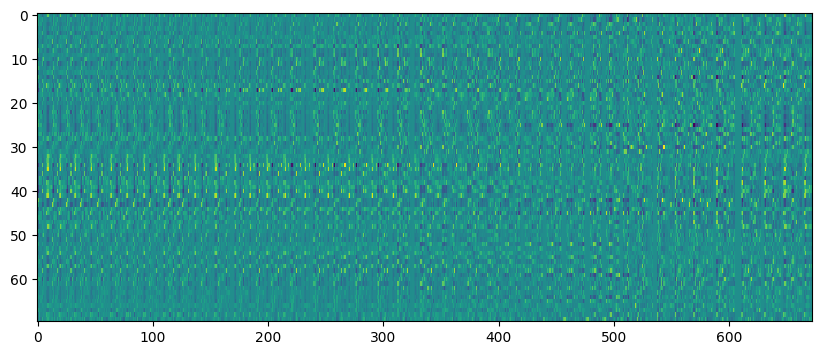

In [96]:
plt.figure(figsize=(10, 4))
plt.imshow(np.array(B), aspect='auto', cmap='viridis', interpolation='none')


Text(0.5, 1.0, 'Explained Variance by PCA')

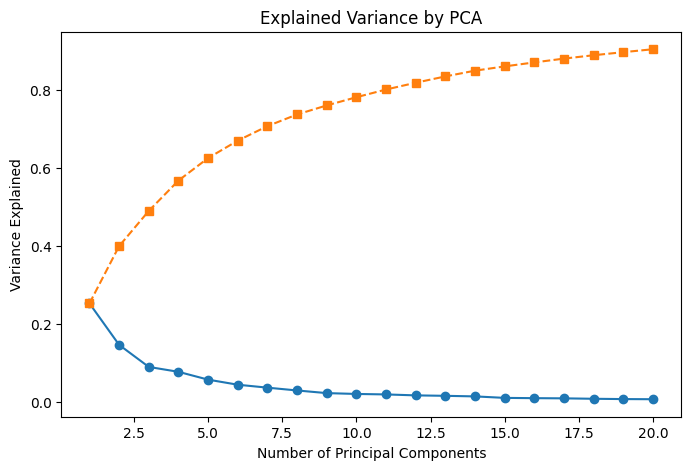

In [103]:
n_components = 20
pca = PCA(n_components)  # Reduce to 50 dimensions
scaler = StandardScaler()

X_pca = pca.fit_transform(np.array(B))

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, n_components+1), explained_variance_ratio, marker='o', label='Individual')
plt.plot(range(1, n_components+1), cumulative_variance, marker='s', label='Cumulative', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Variance Explained")
plt.title("Explained Variance by PCA")

In [112]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=5)
X = X_pca.copy()
mouse_names = df['mouse_name'].drop_duplicates()
y = pd.factorize(mouse_names)[0]
X_lda = lda.fit(X, y).transform(X)

ValueError: The number of samples must be more than the number of classes.

# GLMM
## can be used if prediction is at the trial level

In [84]:
random = {"a": '0 + C(Village)', "b": '0 + C(Village)*year_cen'}
model = BinomialBayesMixedGLM.from_formula(
               'y ~ year_cen', random, data)
result = model.fit_vb()

'3'

In [63]:
group_col

'mouse_id'

In [61]:
features

[Ellipsis]

In [59]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from sklearn.decomposition import PCA

# df: long-format DataFrame
# columns: ['mouse_id', 'session', 'feature1', 'feature2', ..., 'featureN']
df = session_syllables.reset_index().copy()
df = df.rename(columns={col:str(col) for col in df.columns})
features = [col for col in df.columns if col not in ['mouse_name', 'session']]

random_effects = []

# Loop over features
for feature in features:
    # Fit linear mixed model: feature ~ 1 + (1 | mouse_id)
    model = smf.mixedlm(f"{feature} ~ 1", df, groups=df["mouse_name"])
    result = model.fit(reml=True, method='lbfgs')
    
    # Extract random intercepts per mouse
    re = result.random_effects  # dictionary: mouse_id -> intercept value
    mouse_effects = pd.Series({k: v["Group"] for k, v in re.items()})
    random_effects.append(mouse_effects)

# Combine random effects into a DataFrame (mice x features)
B = pd.concat(random_effects, axis=1)
B.columns = features

# Fill missing mice (if some fits failed)
B = B.fillna(0)

# Normalize (optional)
B = (B - B.mean()) / B.std()

# PCA to extract identity domains
pca = PCA(n_components=5)
ID_scores = pca.fit_transform(B)

# Each column of ID_scores is an identity domain
# Each row corresponds to a mouse


PatsyError: model is missing required outcome variables

In [5]:
simpler_mapping = {0.0: 0.0,
        1.0:0,
        2.0:1,
        3.0:2,
        4.0:3,
        5.0:2,
        6.0:3,
        7.0:4,
        
        8.0:5,
        9.0:5,
        10.0:6,
        11.0:7,
        12.0:8,
        13.0:7,
        14.0:8,
        15.0:9,

        16.0:10,
        17.0:10,
        18.0:11,
        19.0:12, 
        20.0:13, 
        21.0:12, 
        22.0:13, 
        23.0:14, 

        24.0:15,
        25.0:15,
        26.0:16,
        27.0:17,
        28.0:18,
        29.0:17,
        30.0:18,
        31.0:19,
        }

replace_func = np.vectorize(simpler_mapping.get)

simpler_identifiable_mapping = {'000': 0.0,
           '100': 0.0,
           '200': 1.0,
           '300': 2.0,
           '400': 3.0,
           '500': 2.0,
           '600': 3.0,
           '700': 4.0,
           
           '010': 5.0,
           '110': 5.0,
           '210': 6.0,
           '310': 7.0,
           '410': 8.0,
           '510': 7.0,
           '610': 8.0,
           '710': 9.0,

           '001': 10.0,
           '101': 10.0,
           '201': 11.0,
           '301': 12.0, 
           '401': 13.0, 
           '501': 12.0, 
           '601': 13.0, 
           '701': 14.0, 

           '011': 15.0,
           '111': 15.0,
           '211': 16.0,
           '311': 17.0,
           '411': 18.0,
           '511': 17.0,
           '611': 18.0,
           '711': 19.0,
           'nan': np.nan
           }
replace_func_identifiable = np.vectorize(simpler_identifiable_mapping.get)

In [25]:
cluster_df = cluster_df.loc[cluster_df['mouse_name'].isin(mice_to_keep)]
all_sequences = all_sequences.loc[all_sequences['mouse_name'].isin(mice_to_keep)]

In [4]:
def expand_from_trial_type(df):
    
    df['feedback'] = df['trial_type'].str.split().str[:1].str.join('')
    df['choice'] = df['trial_type'].str.split().str[3:4].str.join('')
    df['block'] = df['trial_type'].str.split().str[2:3].str.join('')
    df['contrast'] = df['trial_type'].str.split().str[1:2].str.join('')
    df['side'] = df['choice'].copy()
    df.loc[(df['feedback']=='correct') & (df['choice']=='right'), 'side'] = 'left'
    df.loc[(df['feedback']=='correct') & (df['choice']=='left'), 'side'] = 'right'
    df['session'] = df['sample'].str.split().str[:1].str.join('')
    df['trial_id'] = df['sample'].str.split().str[1:2].str.join('')
    df['contrast'] = df['contrast'].astype(float)
    df['block'] = df['block'].astype(float)
    df['choice'] = df['trial_type'].str.split().str[3:4].str.join('')
    df.loc[df['choice']=='left', 'choice'] = 0
    df.loc[df['choice']=='right', 'choice'] = 1
    df.loc[df['feedback']=='correct', 'feedback'] = 1
    df.loc[df['feedback']=='incorrect', 'feedback'] = 0
    
    return df

def group_by_var_interest(session_syllables, var_interest, use_states):

    session_syllables = session_syllables.groupby(['mouse_name', 'session', 'session_cluster', var_interest])[np.arange(0, np.shape(final_matrix)[1], 1)].mean().reset_index()
    
    timesteps = 40
    reshaped_probs = pd.DataFrame()
    clusters = session_syllables['session_cluster'].copy()
    v_int = session_syllables[var_interest].copy()

    for i, interest in enumerate(np.unique(v_int)):
        for c, cluster in enumerate(np.unique(clusters)):
            reshaped_probs_cluster = pd.DataFrame(columns=['syllable', 'timestep', 'cluster', 'prob', var_interest], index=range(use_states * timesteps))
            indices = np.where((session_syllables['session_cluster']==cluster) & (session_syllables[var_interest]==interest))[0]
            syllable_prob = np.array(session_syllables[session_syllables.keys()[4:]])[indices, :].mean(axis=0)

            for t in range(timesteps):
                reshaped_probs_cluster['syllable'][t*use_states:(t+1)*use_states] = ['000', '100', '200', '300', '400', '500', '600', '700', '010', '110',
                            '210', '310', '410', '510', '610', '710', '001', '101', '201', '301', '401', '501', '601', '701', '011',
                            '111', '211', '311', '411', '511',  '611',  '711']
                # reshaped_probs_cluster['syllable'][t*use_states:(t+1)*use_states] = ['000', '100', '200', '300', '400','010', '110',
                #         '210', '310', '410', '001', '101', '201', '301', '401',  '011',
                #         '111', '211', '311', '411']
                reshaped_probs_cluster['timestep'][t*use_states:(t+1)*use_states] = t
                reshaped_probs_cluster['prob'][t*use_states:(t+1)*use_states] = syllable_prob[t*use_states:(t+1)*use_states]
                reshaped_probs_cluster['cluster'][t*use_states:(t+1)*use_states] = cluster
                reshaped_probs_cluster[var_interest][t*use_states:(t+1)*use_states] = interest
            # Save
            reshaped_probs = pd.concat([reshaped_probs, reshaped_probs_cluster])
            
    return reshaped_probs

def group_by_cluster(session_syllables, use_states):

    session_syllables = session_syllables.groupby(['mouse_name', 'session', 'session_cluster'])[np.arange(0, np.shape(final_matrix)[1], 1)].mean().reset_index()
    
    timesteps = 40
    reshaped_probs = pd.DataFrame()
    clusters = session_syllables['session_cluster'].copy()

    for c, cluster in enumerate(np.unique(clusters)):
        reshaped_probs_cluster = pd.DataFrame(columns=['syllable', 'timestep', 'cluster', 'prob'], index=range(use_states * timesteps))
        indices = np.where((session_syllables['session_cluster']==cluster))[0]
        syllable_prob = np.array(session_syllables[session_syllables.keys()[3:]])[indices, :].mean(axis=0)

        for t in range(timesteps):
            reshaped_probs_cluster['syllable'][t*use_states:(t+1)*use_states] = ['000', '100', '200', '300', '400', '500', '600', '700', '010', '110',
                        '210', '310', '410', '510', '610', '710', '001', '101', '201', '301', '401', '501', '601', '701', '011',
                        '111', '211', '311', '411', '511',  '611',  '711']
            # reshaped_probs_cluster['syllable'][t*use_states:(t+1)*use_states] =  ['000', '100', '200', '300', '400','010', '110',
            #             '210', '310', '410', '001', '101', '201', '301', '401',  '011',
            #             '111', '211', '311', '411']
            reshaped_probs_cluster['timestep'][t*use_states:(t+1)*use_states] = t
            reshaped_probs_cluster['prob'][t*use_states:(t+1)*use_states] = syllable_prob[t*use_states:(t+1)*use_states]
            reshaped_probs_cluster['cluster'][t*use_states:(t+1)*use_states] = cluster
        # Save
        reshaped_probs = pd.concat([reshaped_probs, reshaped_probs_cluster])
            
    return reshaped_probs

In [5]:

def group_by_var_interest(session_syllables, var_interest, use_states):

    session_syllables = session_syllables.groupby(['mouse_name', 'session', 'session_cluster', var_interest])[np.arange(0, np.shape(final_matrix)[1], 1)].mean().reset_index()
    
    timesteps = 40
    reshaped_probs = pd.DataFrame()
    clusters = session_syllables['session_cluster'].copy()
    v_int = session_syllables[var_interest].copy()

    for i, interest in enumerate(np.unique(v_int)):
        for c, cluster in enumerate(np.unique(clusters)):
            reshaped_probs_cluster = pd.DataFrame(columns=['syllable', 'timestep', 'cluster', 'prob', var_interest], index=range(use_states * timesteps))
            indices = np.where((session_syllables['session_cluster']==cluster) & (session_syllables[var_interest]==interest))[0]
            syllable_prob = np.array(session_syllables[session_syllables.keys()[4:]])[indices, :].mean(axis=0)

            for t in range(timesteps):
                reshaped_probs_cluster['syllable'][t*use_states:(t+1)*use_states] = ['000', '100', '200', '300', '400', '500', '600', '700', '010', '110',
                            '210', '310', '410', '510', '610', '710', '001', '101', '201', '301', '401', '501', '601', '701', '011',
                            '111', '211', '311', '411', '511',  '611',  '711']
                # reshaped_probs_cluster['syllable'][t*use_states:(t+1)*use_states] = ['000', '100', '200', '300', '400','010', '110',
                #         '210', '310', '410', '001', '101', '201', '301', '401',  '011',
                #         '111', '211', '311', '411']
                reshaped_probs_cluster['timestep'][t*use_states:(t+1)*use_states] = t
                reshaped_probs_cluster['prob'][t*use_states:(t+1)*use_states] = syllable_prob[t*use_states:(t+1)*use_states]
                reshaped_probs_cluster['cluster'][t*use_states:(t+1)*use_states] = cluster
                reshaped_probs_cluster[var_interest][t*use_states:(t+1)*use_states] = interest
            # Save
            reshaped_probs = pd.concat([reshaped_probs, reshaped_probs_cluster])
            
    return reshaped_probs

def group_by_cluster(session_syllables, use_states):

    session_syllables = session_syllables.groupby(['mouse_name', 'session', 'session_cluster'])[np.arange(0, np.shape(final_matrix)[1], 1)].mean().reset_index()
    
    timesteps = 40
    reshaped_probs = pd.DataFrame()
    clusters = session_syllables['session_cluster'].copy()

    for c, cluster in enumerate(np.unique(clusters)):
        reshaped_probs_cluster = pd.DataFrame(columns=['syllable', 'timestep', 'cluster', 'prob'], index=range(use_states * timesteps))
        indices = np.where((session_syllables['session_cluster']==cluster))[0]
        syllable_prob = np.array(session_syllables[session_syllables.keys()[3:]])[indices, :].mean(axis=0)

        for t in range(timesteps):
            reshaped_probs_cluster['syllable'][t*use_states:(t+1)*use_states] = ['000', '100', '200', '300', '400', '500', '600', '700', '010', '110',
                        '210', '310', '410', '510', '610', '710', '001', '101', '201', '301', '401', '501', '601', '701', '011',
                        '111', '211', '311', '411', '511',  '611',  '711']
            # reshaped_probs_cluster['syllable'][t*use_states:(t+1)*use_states] =  ['000', '100', '200', '300', '400','010', '110',
            #             '210', '310', '410', '001', '101', '201', '301', '401',  '011',
            #             '111', '211', '311', '411']
            reshaped_probs_cluster['timestep'][t*use_states:(t+1)*use_states] = t
            reshaped_probs_cluster['prob'][t*use_states:(t+1)*use_states] = syllable_prob[t*use_states:(t+1)*use_states]
            reshaped_probs_cluster['cluster'][t*use_states:(t+1)*use_states] = cluster
        # Save
        reshaped_probs = pd.concat([reshaped_probs, reshaped_probs_cluster])
            
    return reshaped_probs

In [26]:
complete_df = expand_from_trial_type(all_sequences)
complete_df = complete_df.merge(cluster_df[['mouse_name', 'session', 'session_cluster']], on=['mouse_name', 'session'])
# complete_df = complete_df.merge(trial_clusters_df[['mouse_name', 'session', 'trial_id', 'trial_cluster']], on=['mouse_name', 'session', 'trial_id'])

In [27]:
fractions = complete_df.groupby(['session_cluster', 'mouse_name', 'session'])['trial_cluster'].value_counts(normalize=True).rename('fraction').reset_index()

KeyError: 'Column not found: trial_cluster'

<Axes: xlabel='session_cluster', ylabel='fraction'>

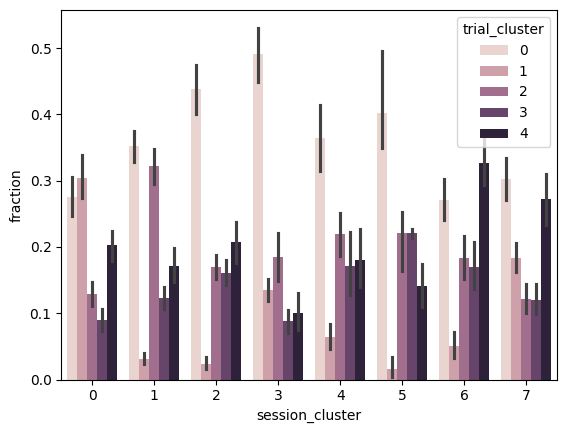

In [7]:
sns.barplot(x='session_cluster', y='fraction', hue='trial_cluster', data=fractions)

## Get sequences per trial

In [ ]:
enough_sessions = cluster_df.groupby('session_cluster')['session_cluster'].count()>10
keep_clusters = np.arange(0, 11, 1)[enough_sessions]
cluster_df = cluster_df.loc[cluster_df['session_cluster'].isin(keep_clusters)]

IndexError: boolean index did not match indexed array along axis 0; size of axis is 11 but size of corresponding boolean axis is 5

In [28]:
var_interest = 'block'
var_interest = ''
if len(var_interest) > 0:
    pivoted_df = complete_df.pivot(index=['sample', 'trial_type', 'mouse_name', 'session', var_interest], columns=['broader_label'], values='binned_sequence').reset_index().dropna()
else:
    pivoted_df = complete_df.pivot(index=['sample', 'trial_type', 'mouse_name', 'session'], columns=['broader_label'], values='binned_sequence').reset_index().dropna()
pivoted_df = pivoted_df.merge(cluster_df[['mouse_name', 'session', 'session_cluster']], on=['mouse_name', 'session'])

In [29]:
epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']

sequences_choice = np.vstack(pivoted_df[epoch_to_analyse].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]



# use_sequences = replace_func(use_sequences)




use_states = int(max(np.unique(use_sequences)))+1
timesteps = np.shape(use_sequences)[1]
binarized = np.zeros((np.shape(use_sequences)[0], timesteps*use_states))

for t in range(timesteps):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(use_states))
    encoded_arr = label_binarizer.transform(use_sequences[:, t])
    binarized[:, t*use_states:(t+1)*use_states] = encoded_arr

final_matrix = binarized.copy()

In [30]:

session_syllables = pd.DataFrame(final_matrix)
session_syllables['session'] = pivoted_df['session'].copy()
session_syllables['session_cluster'] = pivoted_df['session_cluster'].copy()
session_syllables['mouse_name'] = pivoted_df['mouse_name'].copy()
use_states = len(np.unique(use_sequences))

if len(var_interest) > 0:
    session_syllables[var_interest] = pivoted_df[var_interest].copy()
    reshaped_probs = group_by_var_interest(session_syllables, var_interest, use_states)
else:
    reshaped_probs = group_by_cluster(session_syllables, use_states)
clusters = cluster_df['session_cluster']

/tmp/ipykernel_3446/1787296850.py:46: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  reshaped_probs_cluster['syllable'][t*use_states:(t+1)*use_states] = ['000', '100', '200', '300', '400', '500', '600', '700', '010', '110',
/tmp/ipykernel_344

In [31]:
order = ['000', '010', '001', '011', '100', '110', '101', '111', '200', '210', '201', '211',
         '300', '310', '301', '311', '400', '410',  '401', '411',
         '500', '510', '501', '511', '600', '610', '601', '611',
         '700', '710', '701', '711']
labels = ['VL00', 'VL10', 'VL01', 'VL11', 'Low00', 'Low10',  'Low01', 'Low11',
         'Lowish00', 'Lowish10', 'Lowish01', 'Lowish11', 
         'LL-00', 'LL-10', 'LL-01', 'LL-11', 'LR-00', 'LR-10', 'LR-01', 'LR-11', 
         'HL-00', 'HL-10', 'HL-01', 'HL-11', 'HR-00', 'HR-10', 'HR-01', 'HR-11', 
         'H-00', 'H-10', 'H-01', 'H-11']


# order = ['000', '010', '001', '011', 
#          '100', '110', '101', '111', '200', '210', '201', '211',
#          '300', '310', '301', '311', '400', '410',  '401', '411']
# labels = ['Low00', 'Low10',  'Low01', 'Low11',
#          'Lowish00', 'Lowish10', 'Lowish01', 'Lowish11', 
#          'L-00', 'L-10', 'L-01', 'L-11', 'R-00', 'R-10', 'R-01', 'R-11',
#          'H-00', 'H-10', 'H-01', 'H-11']

rename_labels = dict(zip(np.array(order), np.array(labels)))
rename_func = np.vectorize(rename_labels.get)

In [32]:
palette_30 = create_grouped_gradient_palette(n_groups=8, shades_per_group=4, base_palette='Set2')
palette_30_list = [palette_30(i) for i in range(palette_30.N)]  # Extract colors properly

palette_16 = create_grouped_gradient_palette(n_groups=2, shades_per_group=4, base_palette='Set1')
palette_16_list = [palette_16(i) for i in range(palette_16.N)]  # Extract colors properly
state_to_color = dict(zip(order, palette_16_list))

/tmp/ipykernel_3446/3176082635.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['syllable'] = rename_func(use_data['syllable'])
/tmp/ipykernel_3446/3176082635.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['syllable'] = rename_func(use_data['syllable'])
/tmp/ipykernel_3446/3176082635.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

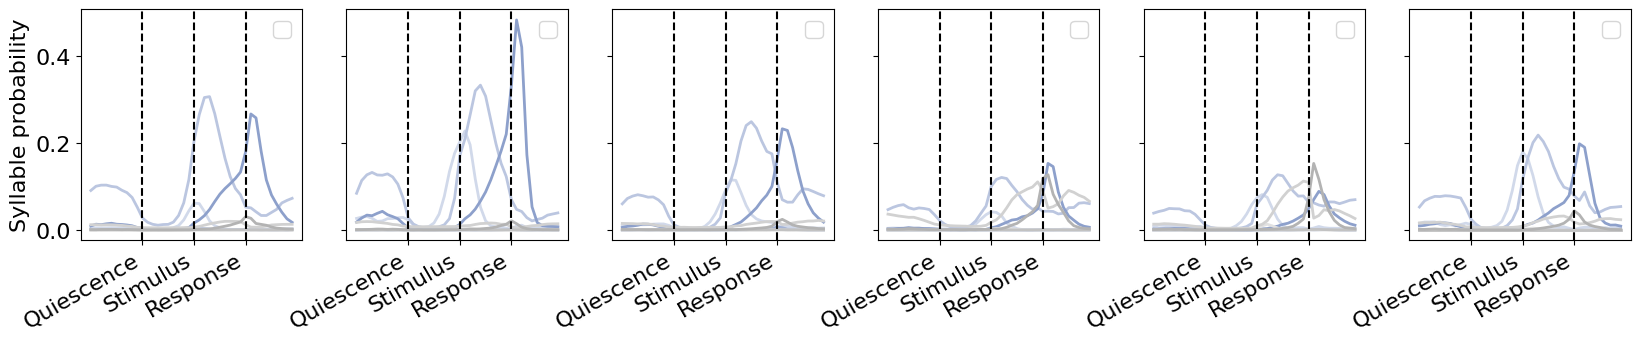

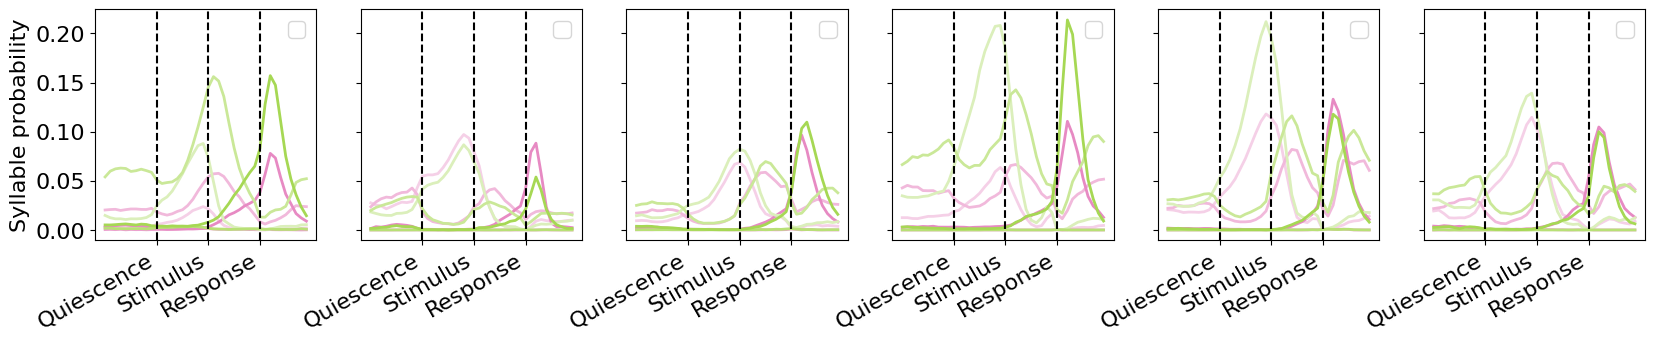

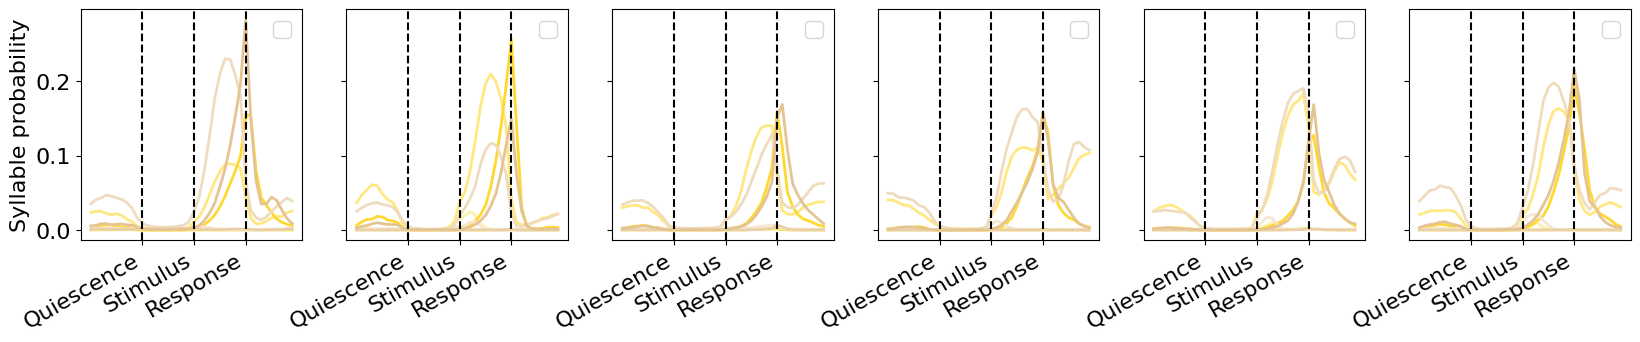

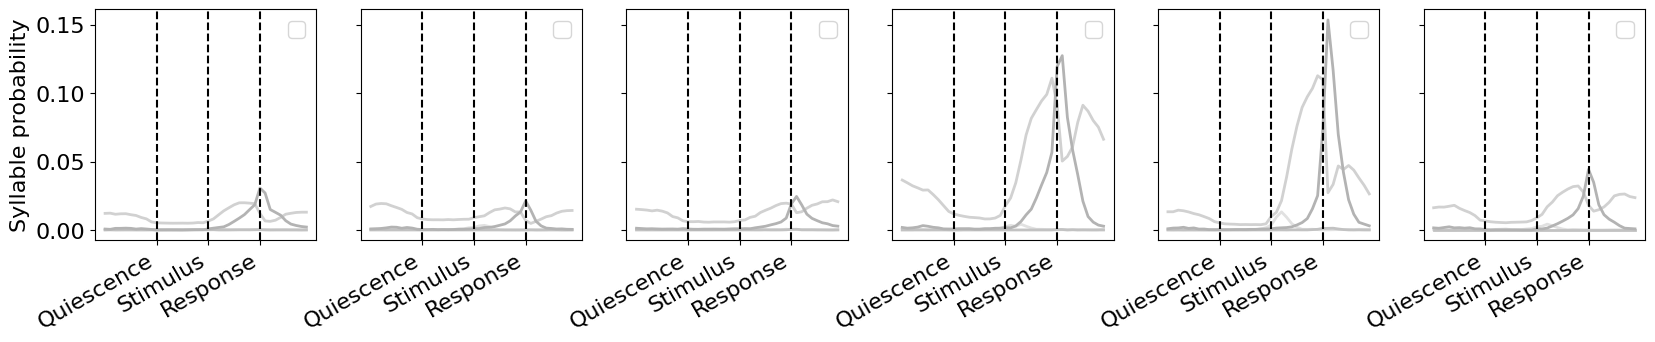

In [34]:
paw_syllable = [['VL00', 'VL10', 'VL01', 'VL11',
                'Low00', 'Low10',  'Low01', 'Low11'],
                ['Lowish00', 'Lowish10', 'Lowish01', 'Lowish11',
                  'H-00', 'H-10', 'H-01', 'H-11'],
                ['LL-00', 'LL-10', 'LL-01', 'LL-11', 'LR-00', 'LR-10', 'LR-01', 'LR-11'],
                ['HL-00', 'HL-10', 'HL-01', 'HL-11', 'HR-00', 'HR-10', 'HR-01', 'HR-11'],
                [ 'H-00', 'H-10', 'H-01', 'H-11']
                ]


# paw_syllable = [['Low00', 'Low10',  'Low01', 'Low11'],
#                 ['Lowish00', 'Lowish10', 'Lowish01', 'Lowish11'],
#                 ['L-00', 'L-10', 'L-01', 'L-11', 'R-00', 'R-10', 'R-01', 'R-11'],
#                 ['H-00', 'H-10', 'H-01', 'H-11']
#                 ]

for i in range(5):

    fig, axs = plt.subplots(1, 6, sharex=True, sharey=True, figsize=(20, 3))

    for c, cluster in enumerate(np.unique(clusters)):
        use_data = reshaped_probs.loc[reshaped_probs['cluster']==cluster]
        use_data['syllable'] = rename_func(use_data['syllable'])
        use_syllables = paw_syllable[i]
        use_data = use_data.loc[use_data['syllable'].isin(use_syllables)]
        sns.lineplot(x='timestep', y='prob', hue='syllable', data=use_data, 
                    ax=axs[c], palette=palette_30_list, hue_order=labels, linewidth=2)  #  legend=labels[c]  style=var_interest,

        axs[c].axvline(x=10, color='k', linestyle='--')
        axs[c].axvline(x=20, color='k', linestyle='--')
        axs[c].axvline(x=30, color='k', linestyle='--')
        axs[c].set_ylabel('Syllable probability')
        axs[c].set_xlabel('')
        # axs[c].set_ylim([0, 0.85])
        axs[c].set_xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')
        axs[c].legend('')
# axs[c].legend(loc='upper left', bbox_to_anchor=(1.1, 1))

# Plot statistics per fingerprint

In [35]:
trials_df = complete_df.drop(columns=['broader_label', 'binned_sequence']).drop_duplicates()
# trials_df = trials_df.merge(cluster_df[['mouse_name', 'session', 'session_cluster']], on=['mouse_name', 'session'])

In [36]:
# Get timing info
data_path = prefix + 'representation_learning_variability/paper-individuality/fig1_segmentation/'
states_file = pd.read_parquet(data_path+'states_trial_type_09-29-2025')
vars = ['trial_id', 'session', 'mouse_name']
elongation = pd.DataFrame(states_file.groupby(vars)['elongation'].mean()).reset_index()
elongation['trial_id'] = elongation['trial_id'].astype(str)
response = pd.DataFrame(states_file.groupby(vars)['response'].mean()).reset_index()
response['trial_id'] = response['trial_id'].astype(str)
reaction = pd.DataFrame(states_file.groupby(vars)['reaction'].mean()).reset_index()
reaction['trial_id'] = reaction['trial_id'].astype(str)

del states_file

# Merge
trials_df = trials_df.merge(elongation, on=['session', 'trial_id', 'mouse_name'])
trials_df = trials_df.merge(response, on=['session', 'trial_id', 'mouse_name'])
trials_df = trials_df.merge(reaction, on=['session', 'trial_id', 'mouse_name'])

In [37]:
data_path = prefix + 'representation_learning_variability/DATA/'
# data_path =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/'
learning_df = pd.read_csv(data_path+'learning_private_one.csv')
learning_times = learning_df[['subject_nickname', 'training_time']].drop_duplicates()
learning_times = learning_times.rename(columns={"subject_nickname": "mouse_name"}).reset_index()

data_path =  prefix + 'representation_learning_variability/DATA/'
learning_df = pd.read_parquet(data_path+'training_time_03-21-2025', engine='pyarrow')
learning_times_new = learning_df.rename(columns={"subject_nickname": "mouse_name"}).reset_index()

# new_df = design_df.droplevel(1, axis=1)[['mouse_name', 'session']]
# df = new_df.merge(learning_times, on='mouse_name')
a = learning_times.merge(learning_times_new, on='mouse_name', how='outer')
b = a.loc[a['training_time_x'].isna()]
b = b.rename(columns={"training_time_y": "training_time"}).reset_index()

full_learning = pd.concat([learning_times[['mouse_name', 'training_time']], b[['mouse_name', 'training_time']]]).reset_index()

/tmp/ipykernel_3446/1096352341.py:3: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  learning_df = pd.read_csv(data_path+'learning_private_one.csv')


In [38]:
trials_df = trials_df.merge(full_learning[['mouse_name', 'training_time']], on='mouse_name')

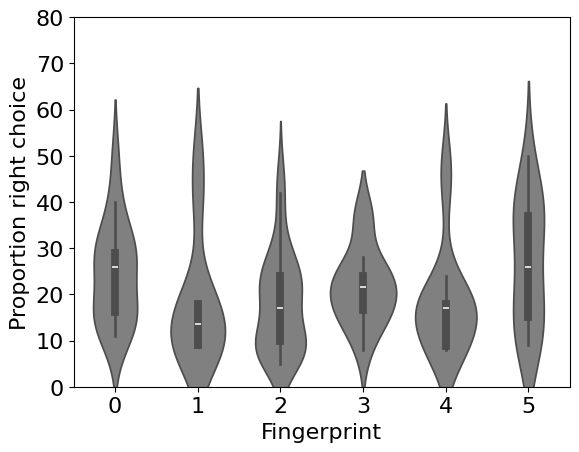

P-value for KW: 0.046
          0         1         2    3         4         5
0  1.000000  0.523565  0.543336  1.0  0.532061  1.000000
1  0.523565  1.000000  1.000000  1.0  1.000000  0.490709
2  0.543336  1.000000  1.000000  1.0  1.000000  0.524970
3  1.000000  1.000000  1.000000  1.0  1.000000  1.000000
4  0.532061  1.000000  1.000000  1.0  1.000000  0.500977
5  1.000000  0.490709  0.524970  1.0  0.500977  1.000000


In [44]:
# --Machine learning and statistics
from scipy.stats import ttest_ind
from sklearn.metrics import f1_score
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
import scikit_posthocs as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats

var_1 = 'training_time ~ session_cluster'
var = 'training_time'
# var = 'elongation'
# var_1 = 'elongation ~ session_cluster'

data = pd.DataFrame(trials_df.groupby(['mouse_name', 'session', 'session_cluster'])[var].mean()).reset_index().dropna()
# data = pd.DataFrame(trials_df.groupby(['mouse_name', 'session_cluster'])[var].mean()).reset_index().dropna()
# data = pd.DataFrame(new_df.groupby(['mouse_name', 'session_cluster'])[var].mean()).reset_index().dropna()
# data = data[['session_cluster', var]]
data[var] = data[var].astype(float)

model = ols(var_1, data=data).fit()

plt.rcParams.update({'font.size': 16})
sns.violinplot(x='session_cluster', y=var, data=data, color='grey') # , palette=sns.light_palette("seagreen", 3, as_cmap=False))
# sns.barplot(x='session_cluster', y=var, data=data, palette=sns.light_palette("seagreen", 3, as_cmap=False))
# sns.scatterplot(x='part_cluster', y=var, data=data, color='black')
# plt.xticks([0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5])
plt.ylim([0, 80])
# plt.ylim([0, 4])
# plt.ylim([0.5, 1])
# plt.ylim([0, 1])
plt.xlabel('Fingerprint')
plt.ylabel('Proportion right choice')
# plt.ylabel('Trial elongation (s)')
# plt.ylabel('Reaction time (s)')
plt.show()
    
#keep_clusters = [ 0,  2,  3,  4,  5,  6,  8, 10]
group_1 = data.loc[data['session_cluster']==0, var]
group_2 = data.loc[data['session_cluster']==1, var]
group_3 = data.loc[data['session_cluster']==2, var]
group_4 = data.loc[data['session_cluster']==3, var]
group_5 = data.loc[data['session_cluster']==4, var]
group_6 = data.loc[data['session_cluster']==5, var]

stat, p_value = stats.kruskal(group_1, group_2, group_3, group_4, group_5, group_6)
# stat, p_value = stats.kruskal(group_1, group_2, group_3, group_4, group_5)


print(f"P-value for KW: {p_value:.3f}")

posthoc = sp.posthoc_dunn(data.dropna(), val_col=var, group_col='session_cluster', p_adjust='bonferroni')
print(posthoc)